# Room Key Data Science Challenge
## Chris Patrick

### Summary

The data confirms at least in part what we might expect: people with __more concrete and more immediate travel plans__ tend to book at higher rates than those who don't. Some observations supporting this:
 - Check-in dates entered at referral for users with bookings average at __26.5 days__ from date of referral, compared with a more distant __36 days__ for all other users.
 - The average time from referral timestamp to lead timestamp is __22.1 minutes__ for the booking group, compared with __28.6 minutes__ for the lead-only group. The medians for the two groups also indicate the booking group is moving more immediately from referral to lead: compare __0.95__ minutes for the booking group with __2.55__ minutes for the lead group. 
 - About half of all records have no udicode, and __98.53%__ of these cases also have __no lead or booking__ associated with them.
 - Most records have a location-tid, but of those that do not, __99.93%__ are not associated with a lead or a booking.
 - Users who entered a past date for check-in at referral had a booking rate of only __0.08%__, as compared with those with a check-in date same date as referral timestamp (__0.13%__) and those with a check-in date in the future (__0.28%__).
 
One potentially contradictory observation is that the average time between first referral timestamp and each of the rest of the referral timestamps for the user increases from __19.2 minutes__ for the referral-only group to __32.7 minutes__ for the lead group and __39.44 minutes__ for the booking group. Although this might indicate less certainty about booking the hotel since more time is being taken, it points to more sustained engagement being a positive indicator of likelihood to book.

__Based on these observations, the possibility of travel should be made more concrete for users.__ This could take the form of asking for missing information such as location-tid/udicode and/or clarification about obviously erroneous information ("You've entered a check-in date in the past. When are you planning to travel?"). Also, some prompts could be added that help make the travel/hotel booking plans more specific. Voter engagement efforts have used questions that prompt potential voters to talk through how they will get to a polling site (https://www.gsb.stanford.edu/insights/research-backed-ways-get-out-vote), and a similar question could be asked of travelers (and answers to such questions would also provide additional data for analysis).

__One caveat__: while some clear differences can be observed between visitors who book and those who don't, predictive models based on the data provided here are not very effective at predicting whether a record with a lead is associated with a booking or whether a user will book. Modeling at the visitor level was slightly better than modeling at the record level, but the best model for predicting the booking group had a precision of only 0.21 and an even worse recall of 0.07, even after upsampling the minority class of the booking group. A full list of the variables included in each model is outlined in the modeling section at the end. To improve the models, user-specific information should be added.

__Some additional observations__:
 - __Mondays__ stand out in particular as having not only more visits, but also being associated with better booking rates.
 - Records with timestamps around __3 pm__ tend to have stronger booking rates than those at any other hour.
 - While IHG has a similar conversion rate as Hilton, their lead-to-referral ratio is much better, leading to a better percentage of referrals becoming bookings.



### Setup

In [1]:
# Install packages
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm
from sklearn import preprocessing, neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from pandas.io.json import json_normalize
import json 
from IPython.display import display
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Allow all columns to be shown
pd.options.display.max_columns = None

# Inline plotting
%matplotlib inline

# Change size of font in plt plots
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

/anaconda3/envs/PY3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/envs/PY3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Read and clean data

In [2]:
# Read in data
dat = pd.read_csv("/Users/chrispatrick/data-science-challenge/data.tsv", sep="\t")

# Check first rows
dat.head()

,referral,lead,booking
0,"{""visitor-id"":""56621b2e-a1d0-4ad0-ad66-dedf8cd...",null,null
1,"{""visitor-id"":""59e2dd41-31ac-42c6-86a4-78b8694...",null,null
2,"{""visitor-id"":""59e2dd35-fb17-486e-9a8f-9a425d4...",null,null
3,"{""visitor-id"":""59e2dd43-b435-45ff-bbdb-2132201...",null,null
4,"{""visitor-id"":""59cb345b-523c-438a-9af7-ee9cd16...",null,null


In [3]:
# Number of rows/columns
dat.shape

(1399157, 3)

In [4]:
# Number of rows with non-null values: 'referral' column
len(dat[dat['referral']!="null"]) # everything has referral

1399157

In [5]:
# Number of rows with non-null values: 'lead' column
len(dat[dat['lead']!="null"]) # 29,278 - some data

29278

In [6]:
# Number of rows with non-null values: 'booking' column
len(dat[dat['booking']!="null"]) # 2,439 - very little data

2439

Referral data

In [7]:
# Join referral column into json string
referral_json = ",".join(dat['referral'])

# Add brackets to enable reading in data as records
referral_json = ''.join(['[', referral_json, ']'])

# Read in referral data as data frame
referral = pd.read_json(referral_json, orient='records')

# Change order of columns 
referral = referral[['visitor-id','event-id','ts','type','partner-code','udicode','location-tid', 
                'check-in','check-out']]

In [8]:
# Check type column to see if values other than 'api.referral' appear
Counter(referral['type'])

Counter({'api.referral': 1399157})

In [9]:
# 'type' does not have any useful information - remove this column
referral = referral.drop('type', axis = 1)

In [10]:
# Change ts to datetime object
referral['ts'] = pd.to_datetime(referral['ts'], unit="ms")

# Change check-in and check-out to dates
referral['check-in'] = pd.to_datetime(referral['check-in'], format='%Y-%m-%d', errors='coerce')
referral['check-out'] = pd.to_datetime(referral['check-out'], format='%Y-%m-%d', errors='coerce')

In [11]:
# Check assumption that all event-ids are unique
len(referral['event-id'].unique()) == len(referral)

True

Lead and booking data

In [12]:
# Identify structure of a non-null value of lead
dat[dat['lead']!="null"].iloc[1]['lead']

'{"visitor-id":"59e2ddb2-f87b-4d0e-8e0a-521339d8eb1f","event-id":"db53c362-a125-4266-9255-19a38e33cc06","ts":1508041134464,"type":"api.lead","rate-partner":"MRT"}'

In [13]:
# Identify structure of a non-null value of booking
dat[dat['booking']!="null"].iloc[1]['booking']

'{"currency":"USD","nights":"1","visitor-id":"59e2df05-19a5-4938-8b52-51c7f793a079","check-in":"20171124","type":"api.booking","check-out":"20171125","rate-partner":"IHG","ts":1508042438224,"rooms":"1","event-id":"59e2e6c6-d95e-40b6-a085-b9253dc4b6f9","total-amount":"102.68"}'

In [14]:
# Change the null lead values to match non-null values
dat['lead'][dat['lead']=="null"] = '{"visitor-id":"","event-id":"","ts":"","type":"","rate-partner":""}'

# Change the null booking values to match non-null values
dat['booking'][dat['booking']=="null"] = \
'{"currency":"","nights":"","visitor-id":"","check-in":"","type":"","check-out":"","rate-partner":"","ts":"","rooms":"","event-id":"","total-amount":""}'

In [15]:
# Join lead and booking columns into json strings
lead_json = ",".join(dat['lead'])
booking_json = ",".join(dat['booking'])

# Add brackets to enable reading in data as records
lead_json = ''.join(['[', lead_json, ']'])
booking_json = ''.join(['[', booking_json, ']'])

# Read in data as data frames
lead = pd.read_json(lead_json, orient='records')
booking = pd.read_json(booking_json, orient='records')

In [16]:
# Check data frame - lead
lead.head()

,event-id,rate-partner,ts,type,visitor-id
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,


In [17]:
# Check data frame - booking
booking.head()

,check-in,check-out,currency,event-id,nights,rate-partner,rooms,total-amount,ts,type,visitor-id
0,,,,,,,,,,,
1,,,,,,,,,,,
2,,,,,,,,,,,
3,,,,,,,,,,,
4,,,,,,,,,,,


In [18]:
# Change ts to datetime object
lead['ts'] = pd.to_datetime(lead['ts'], unit="ms")
booking['ts'] = pd.to_datetime(booking['ts'], unit="ms")

# Booking data only - change check-in and check-out to dates
booking['check-in'] = pd.to_datetime(booking['check-in'], format='%Y-%m-%d', errors='coerce')
booking['check-out'] = pd.to_datetime(booking['check-out'] , format='%Y-%m-%d', errors='coerce')

# Change lead names and order of columns
lead = lead[['visitor-id','event-id','ts','type','rate-partner']]
lead.columns = ['lead_visitor-id', 'lead_event-id', 'lead_ts', 'lead_type', 'lead_rate-partner'] 

# Change booking names and order of columns
booking = booking[['visitor-id','event-id','ts','type','rate-partner','total-amount','currency', \
                'nights','rooms','check-in','check-out']]
booking.columns = ['booking_visitor-id', 'booking_event-id', 'booking_ts', 'booking_type', \
                'booking_rate-partner', 'booking_total-amount','booking_currency', \
                'booking_nights','booking_rooms','booking_check-in','booking_check-out']  

In [19]:
# Check values for lead_type to see if other values besides "api.lead" appear
Counter(lead['lead_type'])

Counter({'': 1369879, 'api.lead': 29278})

In [20]:
# Check values for booking_type to see if anything besides 'api.booking' appears
Counter(booking['booking_type'])

Counter({'': 1396718, 'api.booking': 2439})

In [21]:
# 'type' is not adding information - remove this column
lead = lead.drop('lead_type', axis=1)
booking = booking.drop('booking_type', axis=1)

Join referral, lead, and booking data

In [22]:
# Check that number of rows are equal
len(referral) == len(lead) & len(referral) == len(booking)

True

In [23]:
# Combine data
df = pd.concat(objs=[referral, lead, booking], axis=1)

# Check row where lead_visitor-id and booking visitor-id are not ""
df[(df['lead_visitor-id']!="") & (df['booking_visitor-id']!="")].head(1)

,visitor-id,event-id,ts,partner-code,udicode,location-tid,check-in,check-out,lead_visitor-id,lead_event-id,lead_ts,lead_rate-partner,booking_visitor-id,booking_event-id,booking_ts,booking_rate-partner,booking_total-amount,booking_currency,booking_nights,booking_rooms,booking_check-in,booking_check-out
262,584cd46b-9391-4f06-bde4-347eab8e708b,59e2de3e-7e34-44ff-bea7-6913c9f96b1e,2017-10-15 04:04:14.448,IHG,00WxGaG4X04s8oS05g9krVMw,00eq5gG4X04s5cO05g9krVMw,NaT,NaT,584cd46b-9391-4f06-bde4-347eab8e708b,f52a8b7e-71e1-40ca-b613-21d5d00ce7ae,2017-10-15 04:28:36.444,IHG,584cd46b-9391-4f06-bde4-347eab8e708b,59ec0c47-c905-4c78-9a8d-082d4c09d39c,2017-10-22 03:11:03.851,IHG,164.18,USD,1,1,2017-10-31,2017-11-01


In [24]:
# Change "" values to NA
df.replace('', np.nan, inplace=True)

# Check df
df.head(1)

,visitor-id,event-id,ts,partner-code,udicode,location-tid,check-in,check-out,lead_visitor-id,lead_event-id,lead_ts,lead_rate-partner,booking_visitor-id,booking_event-id,booking_ts,booking_rate-partner,booking_total-amount,booking_currency,booking_nights,booking_rooms,booking_check-in,booking_check-out
0,56621b2e-a1d0-4ad0-ad66-dedf8cdce04e,59e2dd41-0f98-4bd2-8a61-14c6fcc0d6d0,2017-10-15 04:00:01.390,WYND,NaN,0LUmlkG4S04s5cO05g9krVMw,2017-11-03,2017-11-06,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT


### Functions for use in analysis

In [25]:
def summaryStats(df_col, title):
    
    """
    Given a dataframe column and a title for use in output, finds mean, standard deviaton, median, 
    max, and min for values in that column.
    """
    
    # header
    print("\n--", title, "--\n")
    
    # mean
    print("Mean: ", round(df_col.mean(), 3))
    
    # standard deviation
    print("Standard Deviation: ", round(np.std(df_col), 3))
    
    # median
    print("Median: ", df_col.median())

    # max
    print("Max: ", df_col.max())
    
    # min
    print("Min: ", df_col.min())

In [26]:
def plotHist(df_col, val, max_val, title):
    """
    Given a dataframe column, and a value for the figure, a maximum value, 
    and a title, output a histogram for values in that column.
    """
    plt.figure(val)
    plt.figure(figsize=(20,6))
    df_col.plot(kind = 'hist', bins=30, range=(0, max_val))
    plt.title(title)

In [27]:
def summaryStatsReferralLeadBooking(df, column, partial_title, max_val=None, include_referrals=True):
    
    """
    Outputs summary statistics (mean, sd, median, max, min) and creates histograms for a dataframe column 
    for each of three groups:
        - Referral, but no Lead or Booking
        - Referral + Lead, but no Booking
        - Referral + Lead + Booking
    
    Arguments:
        df                - input dataframe
        column            - column to analyze for mean, median, max, min, and plot in histogram;
                            this should be aggregated data (i.e., one and only one value is associated
                            with every occurrence of the visitor-id)
        partial_title     - title to use in histograms. Will be concatenated with information on 
                            subgroup
        max_val           - upper end of range for histograms
        include_referrals - if False, will not output data for referral cases
    """
    
    #### Subset data ####
    
    # Reduce data set to one row per visitor-id
    columns = list(set(['visitor-id', column, 'referral_visitor-id_count', 'lead_visitor-id_count', 
                        'booking_visitor-id_count'])) 
    df_agg = df[columns].drop_duplicates()
 
    df_referral = df_agg[(df_agg['lead_visitor-id_count'].isnull()) & 
                     (df_agg['booking_visitor-id_count'].isnull())]
    
    df_lead     = df_agg[(df_agg['lead_visitor-id_count'].notnull()) & 
                     (df_agg['booking_visitor-id_count'].isnull())]
    
    df_booking  = df_agg[(df_agg['lead_visitor-id_count'].notnull()) & 
                     (df_agg['booking_visitor-id_count'].notnull())]
    
    ##### Summaries #####
    
    # Referral group summary
    if (include_referrals):
        referral_title = partial_title + ': Visitors with Referrals Only'
        summaryStats(df_referral[column], referral_title)
    
    # Lead group summary
    lead_title = partial_title + ': Visitors with a Lead but No Bookings'
    summaryStats(df_lead[column], lead_title)
    
    # Booking group summary
    booking_title = partial_title + ': Visitors with a Booking'
    summaryStats(df_booking[column], booking_title)
    
    ##### Histograms #####
    
    # Set max_value if set to None
    if max_val is None:
        max_val = df_agg[column].max()
    
    if (include_referrals):

        # Referral group histogram
        plotHist(df_referral[column], 1, max_val, referral_title)
        
        val = 2
        
    else:
        
        val = 1
        
    # Lead group histogram
    plotHist(df_lead[column], val, max_val, lead_title)
    
    # Booking group histogram
    plotHist(df_booking[column], val + 1, max_val, booking_title)

### Conversion Rate (Lead:Booking), Referral:Lead, and Referral:Booking for full data set

In [28]:
# Overall conversion rate
conversion_rate = df['booking_visitor-id'].count() / df['lead_visitor-id'].count() * 100
'%.2f' % conversion_rate

'8.33'

In [29]:
# Overall lead:referral ratio
lead_to_referral_rate = df['lead_visitor-id'].count() / df['visitor-id'].count() * 100
'%.2f' % lead_to_referral_rate

'2.09'

In [30]:
# Overall booking:referral ratio
booking_to_referral_rate = df['booking_visitor-id'].count() / df['visitor-id'].count() * 100
'%.2f' % booking_to_referral_rate

'0.17'

### visitor-id investigation

In [31]:
# Number of unique referral visitor-ids
len(df['visitor-id'].unique()) # compare with 1,399,157 - many are duplicated

865596

In [32]:
# Number of unique lead visitor-ids
len(df['lead_visitor-id'].unique()) # compare with 29,278 - some are duplicated, but not many

28345

In [33]:
# Number of unique booking visitor-ids
len(df['booking_visitor-id'].unique()) # compare with 2439 - only a few are duplicated

2434

In [34]:
# Frequency of each visitor-id in referral, lead, and booking data

referral_visitor_freq = pd.crosstab(index=df['visitor-id'], columns='referral_visitor-id_count')
referral_visitor_freq.reset_index(inplace=True)

lead_visitor_freq = pd.crosstab(index=df['lead_visitor-id'], columns='lead_visitor-id_count')
lead_visitor_freq.reset_index(inplace=True)
lead_visitor_freq.rename(columns={'lead_visitor-id':'visitor-id'}, inplace=True)

booking_visitor_freq = pd.crosstab(index=df['booking_visitor-id'], columns='booking_visitor-id_count')
booking_visitor_freq.reset_index(inplace=True)
booking_visitor_freq.rename(columns={'booking_visitor-id':'visitor-id'}, inplace=True)

# Join frequency tables
visitor_freq = referral_visitor_freq.merge(lead_visitor_freq, how='outer').merge(booking_visitor_freq, how='outer')

visitor_freq.sort_values(by='booking_visitor-id_count', ascending=False)

col_0,visitor-id,referral_visitor-id_count,lead_visitor-id_count,booking_visitor-id_count
271376,59e3d3e5-f985-4c73-b482-f55f75526ccd,2.0,2.0,2.0
286333,59e408a6-c6fa-4e1b-ae10-e8357ce26ae9,2.0,2.0,2.0
543667,59e6f482-f2ec-46f8-ad34-5c86b53b0dd4,4.0,2.0,2.0
353424,59e4e70f-6e69-4dbf-8b55-a53c990d4a96,4.0,2.0,2.0
164180,599453db-5415-40a0-9f96-197e25fdf707,6.0,3.0,2.0
176386,59a85897-61a1-4c13-932f-8b8e12538be5,20.0,3.0,2.0
486374,59e64988-7be2-4cee-8d2b-d053d7b74f33,1.0,1.0,1.0
485921,59e648c7-1825-4510-b466-2ec4f9058642,1.0,1.0,1.0
485807,59e6488a-a14e-4b31-9699-b836ba811f7c,1.0,1.0,1.0
484290,59e645ee-c53c-43df-b36a-a9f168e05f64,1.0,1.0,1.0


Based on the information above, it appears that there are records where the visitor ID is ___not___ consistent across referral, lead, and booking. Records where visitor IDs are not consistent will be removed.

In [35]:
# Get count of instances for referral id matching lead id
len(df[df['visitor-id'] == df['lead_visitor-id']]) # compare output with 29,278 - in most cases, they do align

29176

In [36]:
len(df[df['booking_visitor-id'] == df['lead_visitor-id']]) # compare output with 2,439 - more cases of lead
# visitor id not aligning with booking id

2151

In [37]:
len(df[df['visitor-id'] == df['booking_visitor-id']]) # compare output with 2,439 and 2,151 - aligns closely
# with number of booking ids aligning with lead ids

2149

In [38]:
# Subset data based on consistency of ids across referral, lead, and booking columns

# Subset data for rows where there are no leads or bookings
referral_only = df[(df['lead_visitor-id'].isnull()) & (df['booking_visitor-id'].isnull())]

# Subset data for rows where visitor-id matches lead_visitor-id and booking_visitor-id is null
lead = df[(df['booking_visitor-id'].isnull()) & (df['visitor-id'] == df['lead_visitor-id'])]

# Subset data for rows where visitor-id matches both lead_visitor-id and booking_visitor-id
lead_and_booking = df[(df['visitor-id']==df['lead_visitor-id']) &  \
                      (df['visitor-id']==df['booking_visitor-id'])]


# Join referral_only, lead, and lead_and_booking as these are cases where the IDs
# are the same across all columns that have data for that record
df_good_ids = pd.concat([referral_only, lead, lead_and_booking])

# Create a dataframe with records from referral_only, lead, and lead_and_booking removed
df_bad_ids = pd.concat([df, df_good_ids]).drop_duplicates(keep=False)

# Check lengths
len(df_good_ids) + len(df_bad_ids) == len(df)

True

In [39]:
# How many records will be excluded?
len(df_bad_ids)

389

In [40]:
# Frequency tables for visitor-ids across referrals, leads, and bookings

# Create frequency tables for ids in df_good_ids
referral_visitor_freq = pd.crosstab(index=df_good_ids['visitor-id'], columns='referral_visitor-id_count')
referral_visitor_freq.reset_index(inplace=True)

lead_visitor_freq = pd.crosstab(index=df_good_ids['lead_visitor-id'], columns='lead_visitor-id_count')
lead_visitor_freq.reset_index(inplace=True)
lead_visitor_freq.rename(columns={'lead_visitor-id':'visitor-id'}, inplace=True)

booking_visitor_freq = pd.crosstab(index=df_good_ids['booking_visitor-id'], columns='booking_visitor-id_count')
booking_visitor_freq.reset_index(inplace=True)
booking_visitor_freq.rename(columns={'booking_visitor-id':'visitor-id'}, inplace=True)

# Join frequency tables
visitor_freq_good_ids = referral_visitor_freq.merge(lead_visitor_freq, how='outer').merge(booking_visitor_freq, how='outer')

# Check visitor_freq_good_ids
visitor_freq_good_ids.sort_values(by='booking_visitor-id_count', ascending=False).head()

col_0,visitor-id,referral_visitor-id_count,lead_visitor-id_count,booking_visitor-id_count
353290,59e4e70f-6e69-4dbf-8b55-a53c990d4a96,4,2.0,2.0
176330,59a85897-61a1-4c13-932f-8b8e12538be5,20,3.0,2.0
286241,59e408a6-c6fa-4e1b-ae10-e8357ce26ae9,2,2.0,2.0
271295,59e3d3e5-f985-4c73-b482-f55f75526ccd,2,2.0,2.0
543453,59e6f482-f2ec-46f8-ad34-5c86b53b0dd4,4,2.0,2.0


In [41]:
# Join frequency table to df_good_ids
df_good_ids = df_good_ids.merge(visitor_freq_good_ids, how='left')

In [42]:
# Add cumulative count of number of referrals, leads, and bookings for each visitor

# Order df_good_ids by ts
df_good_ids.sort_values(by='ts', inplace=True)

# Check order
df_good_ids['ts'].head()

# Cumulative count by referral visitor-id
df_good_ids['cumulative_referral_count'] = df_good_ids.groupby('visitor-id').cumcount() + 1

# Cumulative count by lead_visitor-id
df_good_ids['cumulative_lead_count'] = df_good_ids.groupby('visitor-id')['lead_visitor-id'].cumcount() + 1 - \
(df_good_ids[df_good_ids['lead_visitor-id'].isnull()].groupby('visitor-id').cumcount() + 1)

df_good_ids.loc[df_good_ids['lead_visitor-id'].notnull(), 'cumulative_lead_count'] = \
 df_good_ids[df_good_ids['lead_visitor-id'].notnull()].groupby('visitor-id')['lead_visitor-id'].cumcount() + 1

# Cumulative count by booking_visitor-id
df_good_ids['cumulative_booking_count'] = df_good_ids.groupby('visitor-id')['booking_visitor-id'].cumcount() + 1 - \
(df_good_ids[df_good_ids['booking_visitor-id'].isnull()].groupby('visitor-id').cumcount() + 1)

df_good_ids.loc[df_good_ids['booking_visitor-id'].notnull(), 'cumulative_booking_count'] = \
 df_good_ids[df_good_ids['booking_visitor-id'].notnull()].groupby('visitor-id')['booking_visitor-id'].cumcount() + 1

# Check counts
df_good_ids[df_good_ids['visitor-id']=='59a85897-61a1-4c13-932f-8b8e12538be5'].head()

,visitor-id,event-id,ts,partner-code,udicode,location-tid,check-in,check-out,lead_visitor-id,lead_event-id,lead_ts,lead_rate-partner,booking_visitor-id,booking_event-id,booking_ts,booking_rate-partner,booking_total-amount,booking_currency,booking_nights,booking_rooms,booking_check-in,booking_check-out,referral_visitor-id_count,lead_visitor-id_count,booking_visitor-id_count,cumulative_referral_count,cumulative_lead_count,cumulative_booking_count
213986,59a85897-61a1-4c13-932f-8b8e12538be5,59e4c07d-8400-4140-b01f-b15ed5b90f37,2017-10-16 14:21:49.190,HLTN,2F7CZUG4S04s5xr05g9krVMw,2FFnrEG4S04s5cO05g9krVMw,2017-10-29,2017-10-30,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,20,3.0,2.0,1,0.0,0.0
221986,59a85897-61a1-4c13-932f-8b8e12538be5,59e4c68d-d7a6-49c0-9e66-44a707f835a9,2017-10-16 14:47:41.113,HLTN,0HmldYG4T04s6Hx05g9krVMw,0HvqcqG4T04s5cO05g9krVMw,2017-10-19,2017-10-20,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,20,3.0,2.0,2,0.0,0.0
223490,59a85897-61a1-4c13-932f-8b8e12538be5,59e4c79a-4f2f-4482-8a31-e6692e02137d,2017-10-16 14:52:10.133,HLTN,0HmldYG4T04s6Hx05g9krVMw,0HvqcqG4T04s5cO05g9krVMw,2017-10-19,2017-10-20,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,20,3.0,2.0,3,0.0,0.0
224249,59a85897-61a1-4c13-932f-8b8e12538be5,59e4c824-1f8d-4624-85c9-a094507d30f3,2017-10-16 14:54:28.182,HLTN,c3969403d1474f89a7f77bd4,0HvqcqG4T04s5cO05g9krVMw,2017-10-19,2017-10-20,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,20,3.0,2.0,4,0.0,0.0
1397244,59a85897-61a1-4c13-932f-8b8e12538be5,59e4c893-87ab-4d58-942b-2440604c4ce4,2017-10-16 14:56:19.506,HLTN,c3969403d1474f89a7f77bd4,0HvqcqG4T04s5cO05g9krVMw,2017-10-19,2017-10-20,59a85897-61a1-4c13-932f-8b8e12538be5,591fd722-7f9e-4ab3-8def-e4e301612c2c,2017-10-16 14:56:29.373,HLTN,59a85897-61a1-4c13-932f-8b8e12538be5,59e4ca45-ec5b-4e69-8c5c-d58a4db8b033,2017-10-16 15:03:33.623,HLTN,198.55,USD,1,1,2017-10-19,2017-10-20,20,3.0,2.0,5,1.0,1.0


In [43]:
# Add a column for prior bookings - we can't use "cumulative booking count" as a predictor,
# but prior bookings would be useful

# Where booking_visitor-id is not null, set prior_booking_count equal to the cumulative_booking_count minus 1. 
# Otherwise set it to the value of cumulative_booking_count.

df_good_ids['prior_booking_count'] = np.where(df_good_ids['booking_visitor-id'].notnull(),
                                             df_good_ids['cumulative_booking_count'] - 1,
                                             df_good_ids['cumulative_booking_count'])

In [44]:
# Check 'prior_booking_count'
df_good_ids[df_good_ids['visitor-id']=='59a85897-61a1-4c13-932f-8b8e12538be5'][['visitor-id', 
                                                                                'booking_visitor-id', 
                                                                                'cumulative_booking_count', 
                                                                                'prior_booking_count']]

,visitor-id,booking_visitor-id,cumulative_booking_count,prior_booking_count
213986,59a85897-61a1-4c13-932f-8b8e12538be5,NaN,0.0,0.0
221986,59a85897-61a1-4c13-932f-8b8e12538be5,NaN,0.0,0.0
223490,59a85897-61a1-4c13-932f-8b8e12538be5,NaN,0.0,0.0
224249,59a85897-61a1-4c13-932f-8b8e12538be5,NaN,0.0,0.0
1397244,59a85897-61a1-4c13-932f-8b8e12538be5,59a85897-61a1-4c13-932f-8b8e12538be5,1.0,0.0
237771,59a85897-61a1-4c13-932f-8b8e12538be5,NaN,1.0,1.0
246614,59a85897-61a1-4c13-932f-8b8e12538be5,NaN,1.0,1.0
251104,59a85897-61a1-4c13-932f-8b8e12538be5,NaN,1.0,1.0
251381,59a85897-61a1-4c13-932f-8b8e12538be5,NaN,1.0,1.0
254992,59a85897-61a1-4c13-932f-8b8e12538be5,NaN,1.0,1.0


Get summary statistics for referrals, leads, and bookings by record and by visitor

In [45]:
# Number of unique visitors
visitor_count = len(df_good_ids['visitor-id'].unique())
visitor_count

865314

In [46]:
### Summary statistics: by record ###

print("---- Summary Statistics by Record ----\n")

# Number of records with referrals only
print("Number of records with only a referral and no lead or booking:", 
      len(df_good_ids[df_good_ids['lead_visitor-id'].isnull()])) 

# Percentage of records with referrals only
print("Percentage of records with only a referral and no lead or booking:", 
      round(len(df_good_ids[df_good_ids['lead_visitor-id'].isnull()]) / len(df_good_ids) * 100, 
            2), "%") 

# Number of records with a lead and no booking
print("Number of records with a lead and no booking:", 
      len(df_good_ids[(df_good_ids['lead_visitor-id'].notnull()) & 
                                   (df_good_ids['booking_visitor-id'].isnull())])) 

# Percentage of records with a lead and no booking
print("Percentage of records with a lead and no booking:", 
      round(len(df_good_ids[(df_good_ids['lead_visitor-id'].notnull()) & 
                                   (df_good_ids['booking_visitor-id'].isnull())]) / len(df_good_ids) * 100, 
            2), "%") 

# Number of records with a booking
print("Number of records with a booking:", 
      len(df_good_ids[df_good_ids['booking_visitor-id'].notnull()])) 

# Percentage of records with a booking
print("Percentage of records with a booking:", 
      round(len(df_good_ids[df_good_ids['booking_visitor-id'].notnull()]) / len(df_good_ids) * 100, 
            2), "%") 

# Percentage of records with a lead that also had a booking
print("Percentage of records with a lead that also had a booking:", 
      round(len(df_good_ids[df_good_ids['booking_visitor-id'].notnull()]) / len(df_good_ids[df_good_ids['lead_visitor-id'].notnull()]) * 100, 
            2), "%") 

### Summary statistics: by visitor ###

print("\n\n---- Summary Statistics by Visitor ----\n")

# Number of visitors with referrals only
print("Number of visitors with only a referral and no leads or bookings:", 
      len(df_good_ids['visitor-id'][df_good_ids['lead_visitor-id_count'].isnull()].unique())) 

# Percentage of visitors with referrals only
print("Percentage of visitors with only a referral and no leads or bookings:", 
      round(len(df_good_ids['visitor-id'][df_good_ids['lead_visitor-id_count'].isnull()].unique()) / visitor_count * 100, 
            2), "%") 

# Number of visitors with leads and no bookings
print("Number of visitors with at least one lead and no booking:", 
      len(df_good_ids['visitor-id'][(df_good_ids['lead_visitor-id_count']>0) & 
                                   (df_good_ids['booking_visitor-id_count'].isnull())].unique())) 

# Percentage of visitors with at least one lead and no booking
print("Percentage of visitors with at least one lead and no booking:", 
      round(len(df_good_ids['visitor-id'][(df_good_ids['lead_visitor-id_count']>0) & 
                                   (df_good_ids['booking_visitor-id_count'].isnull())].unique()) / visitor_count * 100, 
            2), "%") 

# Number of visitors with at least one booking
print("Number of visitors with at least one booking:", 
      len(df_good_ids['visitor-id'][df_good_ids['booking_visitor-id_count']>0].unique())) 

# Percentage of visitors with at least one booking
print("Percentage of visitors with at least one booking:", 
      round(len(df_good_ids['visitor-id'][df_good_ids['booking_visitor-id_count']>0].unique()) / visitor_count * 100, 
            2), "%") 

# Percentage of visitors with at least one lead who also had a booking
print("Percentage of visitors with at least one lead who also had a booking:", 
      round(len(df_good_ids['visitor-id'][df_good_ids['booking_visitor-id_count']>0].unique()) / len(df_good_ids['visitor-id'][df_good_ids['lead_visitor-id_count']>0].unique()) * 100, 
            2), "%") 

---- Summary Statistics by Record ----

Number of records with only a referral and no lead or booking: 1369875
Percentage of records with only a referral and no lead or booking: 97.93 %
Number of records with a lead and no booking: 26748
Percentage of records with a lead and no booking: 1.91 %
Number of records with a booking: 2145
Percentage of records with a booking: 0.15 %
Percentage of records with a lead that also had a booking: 7.42 %


---- Summary Statistics by Visitor ----

Number of visitors with only a referral and no leads or bookings: 837341
Percentage of visitors with only a referral and no leads or bookings: 96.77 %
Number of visitors with at least one lead and no booking: 25834
Percentage of visitors with at least one lead and no booking: 2.99 %
Number of visitors with at least one booking: 2139
Percentage of visitors with at least one booking: 0.25 %
Percentage of visitors with at least one lead who also had a booking: 7.65 %


#### Summary Statistics: Number of Referrals across visitors with:
1. no lead or booking
2. a lead but no booking
3. a booking

_Observations_: The only significant difference between the __lead__ and __booking__ groups is that the booking group appears to have more variance in number of referrals (compare 2.838 SD with 2.066 SD). This could indicate clustering among the 'bookers': those who know exactly what they want and book without shopping around and those who take time to explore multiple options. Both groups differ from the __referral__ group in having more referrals on average.


-- Summary Statistics: Number of Referrals: Visitors with Referrals Only --

Mean:  1.604
Standard Deviation:  1.605
Median:  1.0
Max:  237
Min:  1

-- Summary Statistics: Number of Referrals: Visitors with a Lead but No Bookings --

Mean:  1.992
Standard Deviation:  2.066
Median:  1.0
Max:  38
Min:  1

-- Summary Statistics: Number of Referrals: Visitors with a Booking --

Mean:  1.98
Standard Deviation:  2.838
Median:  1.0
Max:  59
Min:  1


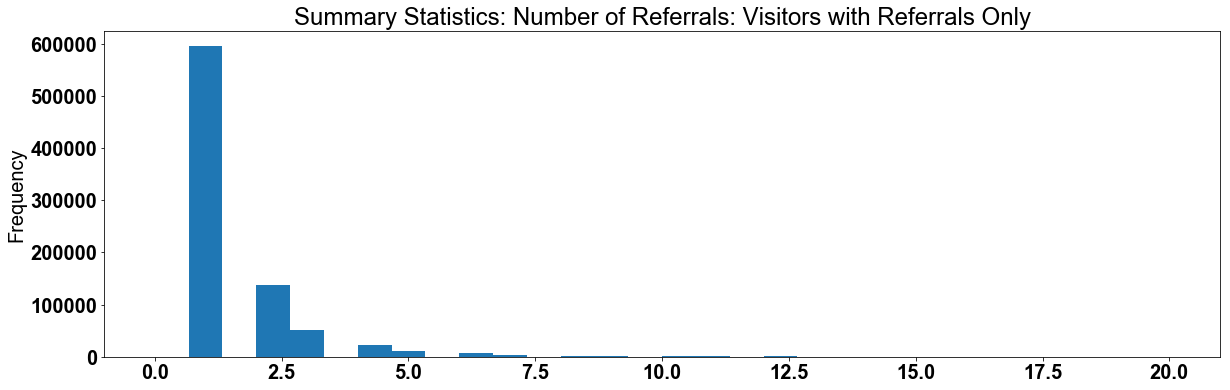

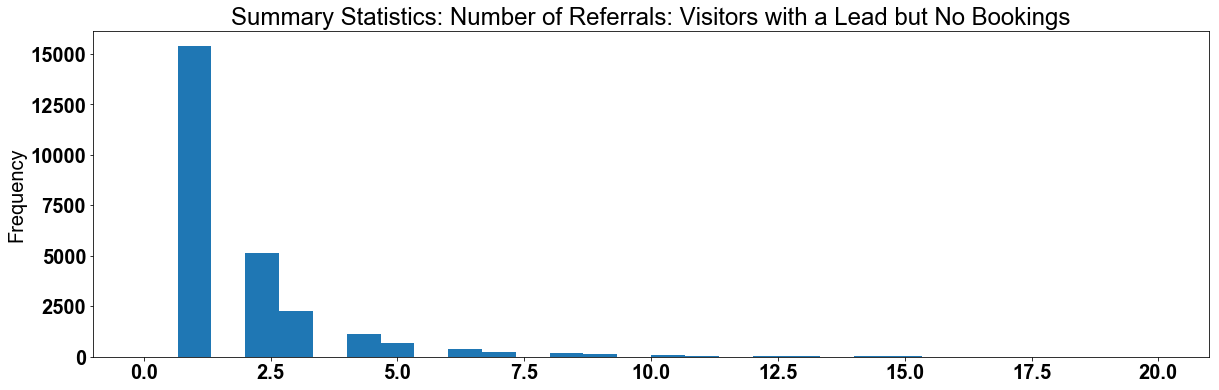

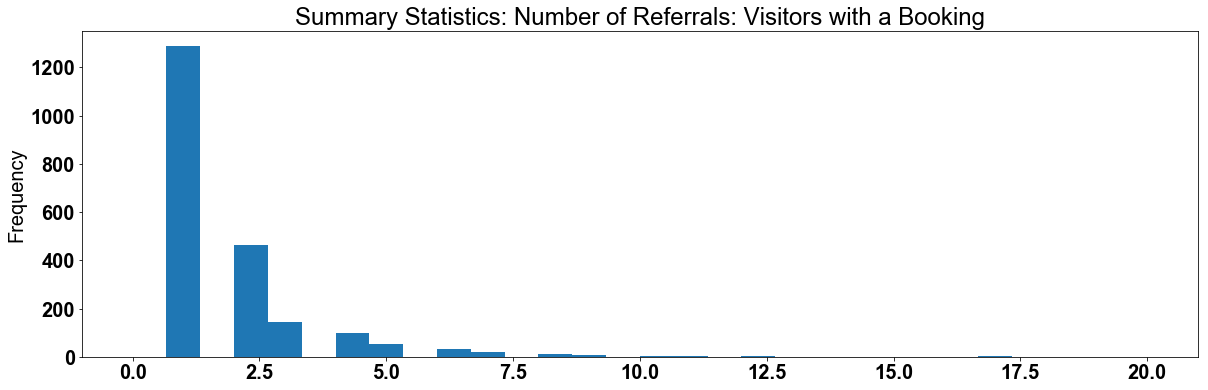

In [47]:
summaryStatsReferralLeadBooking(df_good_ids, 'referral_visitor-id_count', 'Summary Statistics: Number of Referrals',
                               max_val=20)

#### Summary Statistics: Number of Leads across visitors with:
1. a lead but no booking
2. a booking

_Observations_: Little variation between __lead__ and __booking__ groups; both tend to have a single lead.


-- Summary Statistics: Number of Leads: Visitors with a Lead but No Bookings --

Mean:  1.032
Standard Deviation:  0.195
Median:  1.0
Max:  5.0
Min:  1.0

-- Summary Statistics: Number of Leads: Visitors with a Booking --

Mean:  1.049
Standard Deviation:  0.244
Median:  1.0
Max:  4.0
Min:  1.0


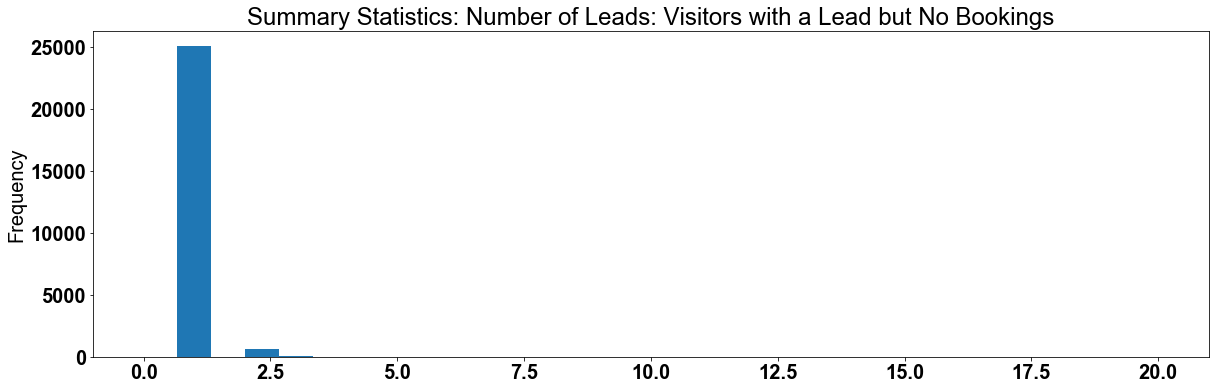

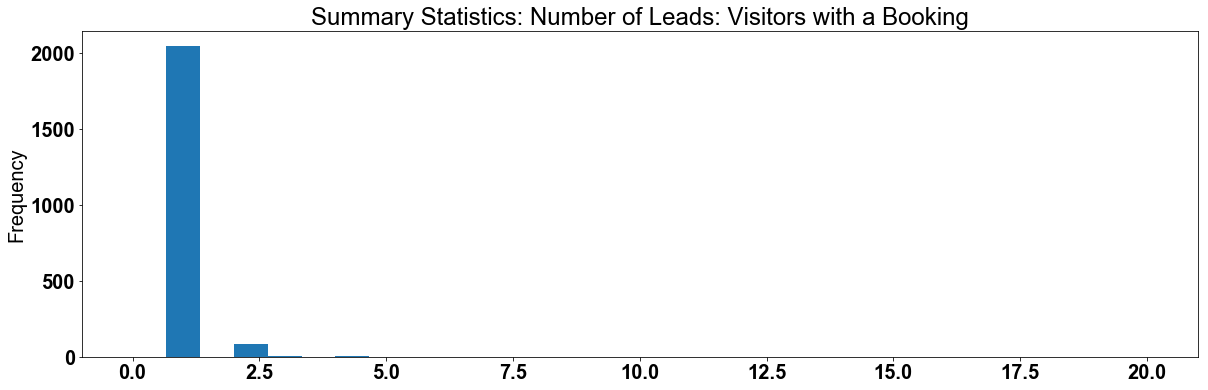

In [48]:
summaryStatsReferralLeadBooking(df_good_ids, 'lead_visitor-id_count', 'Summary Statistics: Number of Leads',
                               max_val=20, include_referrals=False)

### Hotel partner investigaton

#### Referral, Lead, and Booking Statistics by Hotel Partner

In [49]:
# Frequency table for referral partners
partner_ref_df = pd.crosstab(index=df['partner-code'], columns="Referral_Count")
partner_ref_df['Referral_Percentage'] = partner_ref_df['Referral_Count'] / partner_ref_df['Referral_Count'].sum()
partner_ref_df.reset_index(inplace=True)
partner_ref_df.sort_values(by="Referral_Percentage", ascending=False)

col_0,partner-code,Referral_Count,Referral_Percentage
1,HLTN,574688,0.410739
4,MRT,347492,0.248358
3,IHG,253568,0.181229
0,CHC,99409,0.071049
6,WYND,75330,0.053840
2,HYAT,48557,0.034704
5,PHG,113,0.000081


In [50]:
# Frequency table for lead partners
partner_lead_df = pd.crosstab(index=df['lead_rate-partner'], columns=["Lead_Count"])
partner_lead_df['Lead_Percentage'] = partner_lead_df['Lead_Count'] / partner_lead_df['Lead_Count'].sum()
partner_lead_df.reset_index(inplace=True)
partner_lead_df.rename(columns={"lead_rate-partner":"partner-code"}, inplace=True)
partner_lead_df.sort_values(by="Lead_Percentage", ascending=False)

col_0,partner-code,Lead_Count,Lead_Percentage
3,HLTN,8952,0.305759
6,MRT,7418,0.253364
5,IHG,6344,0.216681
2,CHC,2386,0.081495
13,WYND,1058,0.036136
11,TCLK,1024,0.034975
4,HYAT,822,0.028076
10,STRWD,594,0.020288
8,SABR,319,0.010896
7,PEGS,247,0.008436


In [51]:
# Frequency table for booking partners
partner_book_df = pd.crosstab(index=df['booking_rate-partner'], columns="Booking_Count")
partner_book_df.index.names = ['partner-code'] # rename index so matches other dfs
partner_book_df['Booking_Percentage'] = partner_book_df['Booking_Count'] / partner_book_df['Booking_Count'].sum()
partner_book_df.reset_index(inplace=True)
partner_book_df.rename(columns={"booking_rate-partner":"partner-code"}, inplace=True)
partner_book_df.sort_values(by="Booking_Percentage", ascending=False)

col_0,partner-code,Booking_Count,Booking_Percentage
1,HLTN,1021,0.418614
3,IHG,709,0.290693
4,MRT,620,0.254203
0,CHC,65,0.026650
5,PEGS,9,0.003690
6,STRWD,7,0.002870
7,WYND,6,0.002460
2,HYAT,2,0.000820


In [52]:
# Join frequency tables
partner_freq = partner_ref_df.merge(partner_lead_df, how='outer').merge(partner_book_df, how='outer')
partner_freq.sort_values(by="Booking_Percentage", ascending=False)

col_0,partner-code,Referral_Count,Referral_Percentage,Lead_Count,Lead_Percentage,Booking_Count,Booking_Percentage
1,HLTN,574688.0,0.410739,8952.0,0.305759,1021.0,0.418614
3,IHG,253568.0,0.181229,6344.0,0.216681,709.0,0.290693
4,MRT,347492.0,0.248358,7418.0,0.253364,620.0,0.254203
0,CHC,99409.0,0.071049,2386.0,0.081495,65.0,0.026650
9,PEGS,NaN,NaN,247.0,0.008436,9.0,0.003690
12,STRWD,NaN,NaN,594.0,0.020288,7.0,0.002870
6,WYND,75330.0,0.053840,1058.0,0.036136,6.0,0.002460
2,HYAT,48557.0,0.034704,822.0,0.028076,2.0,0.000820
5,PHG,113.0,0.000081,NaN,NaN,NaN,NaN
7,BW,NaN,NaN,46.0,0.001571,NaN,NaN


In [53]:
# Get Booking:Lead, Lead:Referral, and Booking:Referral ratios for hotel partners
partner_freq['Booking_to_Lead'] = partner_freq['Booking_Count'] / partner_freq['Lead_Count']
partner_freq['Booking_to_Referral'] = partner_freq['Booking_Count'] / partner_freq['Referral_Count']
partner_freq['Lead_to_Referral'] = partner_freq['Lead_Count'] / partner_freq['Referral_Count']
partner_freq.sort_values(by="Booking_to_Lead", ascending=False)

col_0,partner-code,Referral_Count,Referral_Percentage,Lead_Count,Lead_Percentage,Booking_Count,Booking_Percentage,Booking_to_Lead,Booking_to_Referral,Lead_to_Referral
1,HLTN,574688.0,0.410739,8952.0,0.305759,1021.0,0.418614,0.114053,0.001777,0.015577
3,IHG,253568.0,0.181229,6344.0,0.216681,709.0,0.290693,0.111759,0.002796,0.025019
4,MRT,347492.0,0.248358,7418.0,0.253364,620.0,0.254203,0.083580,0.001784,0.021347
9,PEGS,NaN,NaN,247.0,0.008436,9.0,0.003690,0.036437,NaN,NaN
0,CHC,99409.0,0.071049,2386.0,0.081495,65.0,0.026650,0.027242,0.000654,0.024002
12,STRWD,NaN,NaN,594.0,0.020288,7.0,0.002870,0.011785,NaN,NaN
6,WYND,75330.0,0.053840,1058.0,0.036136,6.0,0.002460,0.005671,0.000080,0.014045
2,HYAT,48557.0,0.034704,822.0,0.028076,2.0,0.000820,0.002433,0.000041,0.016929
5,PHG,113.0,0.000081,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BW,NaN,NaN,46.0,0.001571,NaN,NaN,NaN,NaN,NaN


_Hotel partner conversion observations_: Hilton and IHG are converting similar percentages of leads, but referrals from IHG are more likely to become leads, leading to a better booking-to-referral ratio.

#### Visitor-id and hotel partner investigation

Referral hotel partners

In [54]:
# Cumulative counts of unique referral hotel partners by visitor-id

# Arrange df_good_ids by visitor-id and ts
df_good_ids.sort_values(by=['visitor-id', 'ts'], inplace=True)

# Add rownames to df
df_good_ids['id'] = df_good_ids.index

# Get cumulative count of unique values for referral hotel partner
unique_rhp_count = df_good_ids[['visitor-id', 'partner-code']].drop_duplicates().groupby('visitor-id').cumcount() + 1
unique_rhp_count_df = unique_rhp_count.reindex(df_good_ids.id).ffill().to_frame()
unique_rhp_count_df.reset_index(level=0, inplace=True)
unique_rhp_count_df.rename(columns={1: 'id', 0:'cumulative_referral_hotel_count'}, inplace=True)

# Merge to df_good_ids
df_good_ids = df_good_ids.merge(unique_rhp_count_df, on='id')

# Check dataframe
df_good_ids[df_good_ids['visitor-id']=='59a85897-61a1-4c13-932f-8b8e12538be5'][['visitor-id', 'ts',
                                                                                'partner-code', 
                                                                                'cumulative_referral_hotel_count']].head()

,visitor-id,ts,partner-code,cumulative_referral_hotel_count
322032,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:21:49.190,HLTN,1.0
322033,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:47:41.113,HLTN,1.0
322034,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:52:10.133,HLTN,1.0
322035,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:54:28.182,HLTN,1.0
322036,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:56:19.506,HLTN,1.0


Lead rate partners

In [55]:
# Subset df_good_ids based on whether first lead_rate-partner is null or not, as each group
# will require a different approach for cumulative counts

# Identify first referral for each visitor
first_referral = df_good_ids[df_good_ids['cumulative_referral_count']==1]

# Subset first_referral by those that have 0 or 1 for cumulative lead count
first_referral_no_lead = first_referral[first_referral['cumulative_lead_count']==0]
first_referral_with_lead = first_referral[first_referral['cumulative_lead_count']==1]

# Subset df_good_ids for those in each dataframe
first_referral_no_lead_df = df_good_ids[df_good_ids['visitor-id'].isin(first_referral_no_lead['visitor-id'])]
first_referral_with_lead_df = df_good_ids[df_good_ids['visitor-id'].isin(first_referral_with_lead['visitor-id'])]

# Order by id and then by date
first_referral_no_lead_df = first_referral_no_lead_df.sort_values(by=['visitor-id', 'ts'])
first_referral_with_lead_df = first_referral_with_lead_df.sort_values(by=['visitor-id', 'ts'])

# Check that the number of rows matches df_good_ids
len(first_referral_no_lead_df) + len(first_referral_with_lead_df) == len(df_good_ids)

True

In [56]:
# Cumulative counts of unique rate partners for both lead groups by visitor-id

# Reindex both dataframes
first_referral_no_lead_df['id'] = first_referral_no_lead_df.index
first_referral_with_lead_df['id'] = first_referral_with_lead_df.index

# Cumulative count of unique values for lead rate partner by visitor-id
unique_lrp_count_no_lead = first_referral_no_lead_df[['visitor-id', 'lead_rate-partner']].drop_duplicates().groupby('visitor-id').cumcount()
unique_lrp_count_no_lead = unique_lrp_count_no_lead.reindex(first_referral_no_lead_df.id).ffill().to_frame()
unique_lrp_count_no_lead.reset_index(level=0, inplace=True)
unique_lrp_count_no_lead.rename(columns={1: 'id', 0:'cumulative_lead_hotel_count'}, inplace=True)

unique_lrp_count_with_lead = first_referral_with_lead_df[first_referral_with_lead_df['lead_rate-partner'].notnull()][['visitor-id', 'lead_rate-partner']].drop_duplicates().groupby('visitor-id').cumcount() + 1
unique_lrp_count_with_lead = unique_lrp_count_with_lead.reindex(first_referral_with_lead_df.id).ffill().to_frame()
unique_lrp_count_with_lead.reset_index(level=0, inplace=True)
unique_lrp_count_with_lead.rename(columns={1: 'id', 0:'cumulative_lead_hotel_count'}, inplace=True)

# Merge to dataframes
first_referral_no_lead_df = first_referral_no_lead_df.merge(unique_lrp_count_no_lead, how='left', on='id')
first_referral_with_lead_df = first_referral_with_lead_df.merge(unique_lrp_count_with_lead, how='left', on='id')

# Join dataframes together, overwriting df_good_ids
df_good_ids = pd.concat([first_referral_no_lead_df, first_referral_with_lead_df])

Booking rate partners

In [57]:
# Subset df_good_ids based on whether first booking_rate-partner is null or not

# Subset first_referral by those that have 0 or 1 for cumulative booking count
first_referral_no_booking = first_referral[first_referral['cumulative_booking_count']==0]
first_referral_with_booking = first_referral[first_referral['cumulative_booking_count']==1]

# Subset df_good_ids for those in each dataframe
first_referral_no_booking_df = df_good_ids[df_good_ids['visitor-id'].isin(first_referral_no_booking['visitor-id'])]
first_referral_with_booking_df = df_good_ids[df_good_ids['visitor-id'].isin(first_referral_with_booking['visitor-id'])]

# Order by id and then by date
first_referral_no_booking_df = first_referral_no_booking_df.sort_values(by=['visitor-id', 'ts'])
first_referral_with_booking_df = first_referral_with_booking_df.sort_values(by=['visitor-id', 'ts'])

# Check that the number of rows matches df_good_ids
len(first_referral_no_booking_df) + len(first_referral_with_booking_df) == len(df_good_ids)

True

In [58]:
# Cumulative counts of unique rate partners for both booking groups by visitor-id

# Reset index for both data frames
first_referral_no_booking_df.reset_index(inplace=True)
first_referral_with_booking_df.reset_index(inplace=True)
first_referral_no_booking_df['id'] = first_referral_no_booking_df.index
first_referral_with_booking_df['id'] = first_referral_with_booking_df.index

# Get cumulative count of unique values for booking rate partner
unique_brp_count_no_booking = first_referral_no_booking_df[['visitor-id', 'booking_rate-partner']].drop_duplicates().groupby('visitor-id').cumcount()
unique_brp_count_no_booking = unique_brp_count_no_booking.reindex(first_referral_no_booking_df.id).ffill().to_frame()
unique_brp_count_no_booking.reset_index(level=0, inplace=True)
unique_brp_count_no_booking.rename(columns={1: 'id', 0:'cumulative_booking_hotel_count'}, inplace=True)

unique_brp_count_with_booking = first_referral_with_booking_df[first_referral_with_booking_df['booking_rate-partner'].notnull()][['visitor-id', 'booking_rate-partner']].drop_duplicates().groupby('visitor-id').cumcount() + 1
unique_brp_count_with_booking = unique_brp_count_with_booking.reindex(first_referral_with_booking_df.id).ffill().to_frame()
unique_brp_count_with_booking.reset_index(level=0, inplace=True)
unique_brp_count_with_booking.rename(columns={1: 'id', 0:'cumulative_booking_hotel_count'}, inplace=True)

# Merge to dataframes
first_referral_no_booking_df = first_referral_no_booking_df.merge(unique_brp_count_no_booking, how='left', on='id')
first_referral_with_booking_df = first_referral_with_booking_df.merge(unique_brp_count_with_booking, how='left', on='id')

# Join dataframes together, overwriting df_good_ids
df_good_ids = pd.concat([first_referral_no_booking_df, first_referral_with_booking_df])

# Remove id columns
df_good_ids = df_good_ids.drop(['id', 'index'], axis=1)

# Check columns
df_good_ids.columns

Index(['visitor-id', 'event-id', 'ts', 'partner-code', 'udicode',
       'location-tid', 'check-in', 'check-out', 'lead_visitor-id',
       'lead_event-id', 'lead_ts', 'lead_rate-partner', 'booking_visitor-id',
       'booking_event-id', 'booking_ts', 'booking_rate-partner',
       'booking_total-amount', 'booking_currency', 'booking_nights',
       'booking_rooms', 'booking_check-in', 'booking_check-out',
       'referral_visitor-id_count', 'lead_visitor-id_count',
       'booking_visitor-id_count', 'cumulative_referral_count',
       'cumulative_lead_count', 'cumulative_booking_count',
       'prior_booking_count', 'cumulative_referral_hotel_count',
       'cumulative_lead_hotel_count', 'cumulative_booking_hotel_count'],
      dtype='object')

In [59]:
# Check df
df_good_ids[df_good_ids['visitor-id']=='59a85897-61a1-4c13-932f-8b8e12538be5'][['visitor-id', 'ts',
                                                                                'partner-code', 
                                                                                'lead_rate-partner',
                                                                                'booking_rate-partner',
                                                                                'cumulative_referral_hotel_count',
                                                                                'cumulative_lead_hotel_count',
                                                                                'cumulative_booking_hotel_count']].head(20)

,visitor-id,ts,partner-code,lead_rate-partner,booking_rate-partner,cumulative_referral_hotel_count,cumulative_lead_hotel_count,cumulative_booking_hotel_count
321546,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:21:49.190,HLTN,NaN,NaN,1.0,0.0,0.0
321547,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:47:41.113,HLTN,NaN,NaN,1.0,0.0,0.0
321548,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:52:10.133,HLTN,NaN,NaN,1.0,0.0,0.0
321549,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:54:28.182,HLTN,NaN,NaN,1.0,0.0,0.0
321550,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 14:56:19.506,HLTN,HLTN,HLTN,1.0,1.0,1.0
321551,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 15:35:00.417,HLTN,NaN,NaN,1.0,1.0,1.0
321552,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 16:01:56.289,HLTN,NaN,NaN,1.0,1.0,1.0
321553,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 16:16:00.791,CHC,NaN,NaN,2.0,1.0,1.0
321554,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 16:16:56.346,CHC,NaN,NaN,2.0,1.0,1.0
321555,59a85897-61a1-4c13-932f-8b8e12538be5,2017-10-16 16:28:24.875,HLTN,NaN,NaN,2.0,1.0,1.0


In [60]:
# Add summative counts of unique values for referral hotel partner, lead hotel partner, and booking hotel partner

df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['cumulative_referral_hotel_count'].max(), 
                               on='visitor-id', rsuffix='_max')

df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['cumulative_lead_hotel_count'].max(), 
                               on='visitor-id', rsuffix='_max')

df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['cumulative_booking_hotel_count'].max(), 
                               on='visitor-id', rsuffix='_max')

# Rename columns
df_good_ids.rename(columns={'cumulative_referral_hotel_count_max':'referral_hotel_count',
                           'cumulative_lead_hotel_count_max': 'lead_hotel_count',
                           'cumulative_booking_hotel_count_max': 'booking_hotel_count'}, inplace=True)

### Summary Statistics: Counts of unique referral hotel partner-codes across visitors with:
1. no lead or booking
2. a lead but no booking
3. a booking

_Observations_: Not much difference between the three groups, although the __booking__ group has a slightly lower mean and SD than the __lead only__ group. However, the lowest number of distinct referral hotel partners is the __referral only__ group.


-- Summary Statistics: Number of Unique Referral Partner-Codes: Visitors with Referrals Only --

Mean:  1.093
Standard Deviation:  0.335
Median:  1.0
Max:  7.0
Min:  1.0

-- Summary Statistics: Number of Unique Referral Partner-Codes: Visitors with a Lead but No Bookings --

Mean:  1.188
Standard Deviation:  0.471
Median:  1.0
Max:  6.0
Min:  1.0

-- Summary Statistics: Number of Unique Referral Partner-Codes: Visitors with a Booking --

Mean:  1.151
Standard Deviation:  0.426
Median:  1.0
Max:  5.0
Min:  1.0


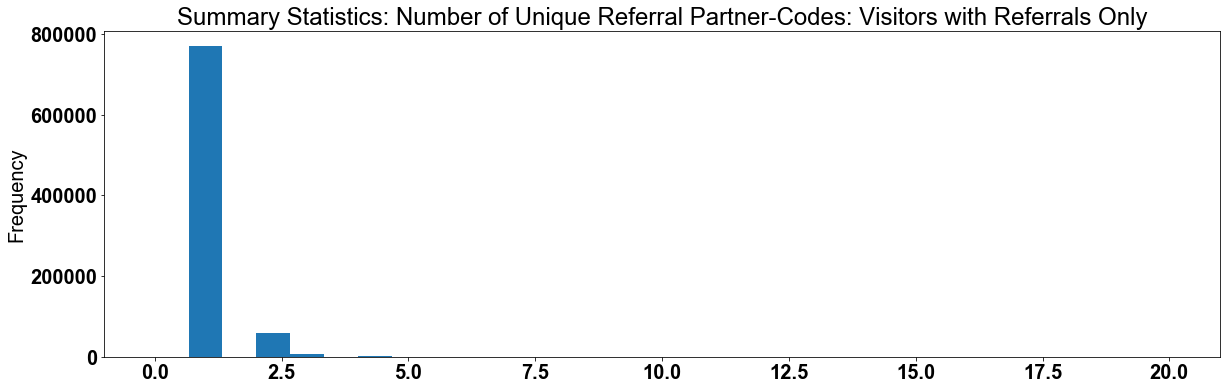

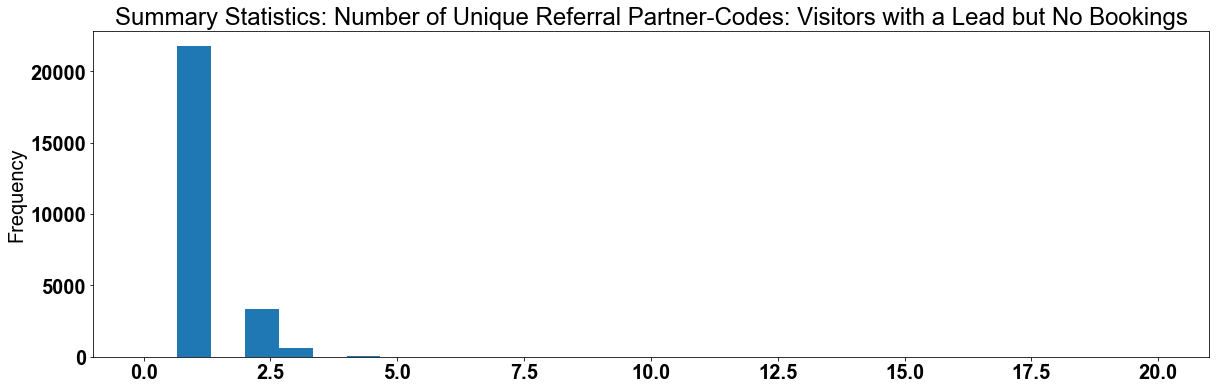

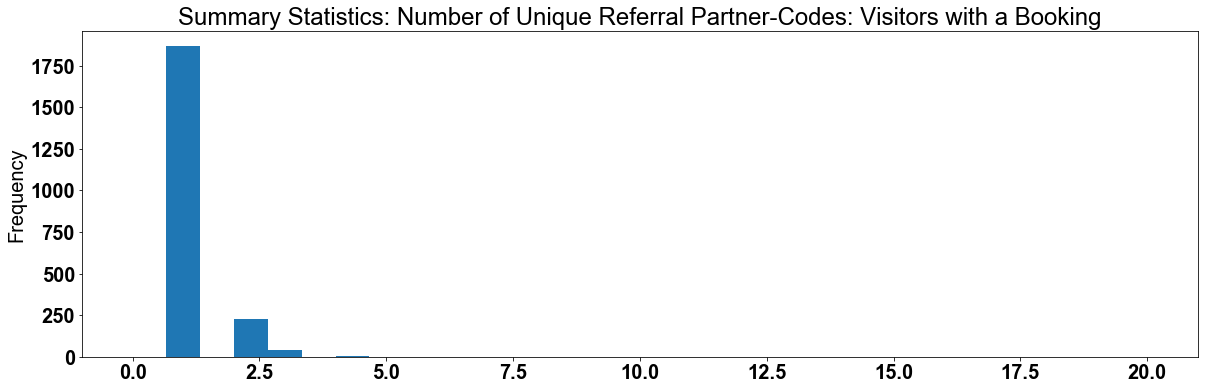

In [61]:
summaryStatsReferralLeadBooking(df_good_ids, 'referral_hotel_count', 
                                'Summary Statistics: Number of Unique Referral Partner-Codes', max_val=20)

### Summary Statistics: Counts of unique lead partner-codes across visitors with:
1. a lead but no booking
2. a booking

_Observations_: As with number of leads, the __lead__ and __booking__ groups differ little in terms of count of unique lead partner-codes. However, the trend observed in the count of referral partner-codes is reversed: here, the __booking__ group has a very slightly higher mean and SD. 


-- Summary Statistics: Number of Unique Lead Partner-Codes: Visitors with a Lead but No Bookings --

Mean:  1.016
Standard Deviation:  0.13
Median:  1.0
Max:  3.0
Min:  1.0

-- Summary Statistics: Number of Unique Lead Partner-Codes: Visitors with a Booking --

Mean:  1.022
Standard Deviation:  0.148
Median:  1.0
Max:  3.0
Min:  1.0


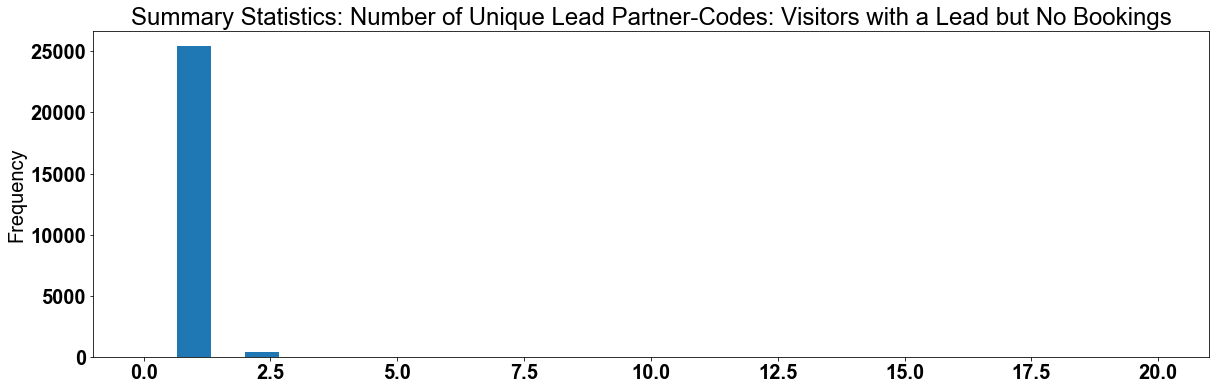

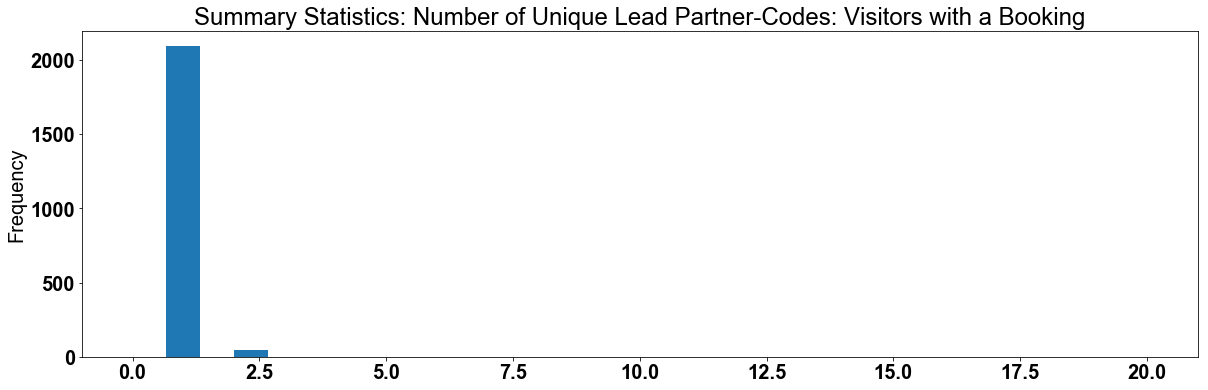

In [62]:
summaryStatsReferralLeadBooking(df_good_ids, 'lead_hotel_count', 
                                'Summary Statistics: Number of Unique Lead Partner-Codes', 
                                max_val=20, include_referrals=False)

### referral ts to lead ts investigation

How long do visitors take between referral and lead? Is there a difference between those who book and those who do not?

In [63]:
# Difference between lead time stamp and referral time stamp
df_good_ids['referral_to_lead_ts_mins'] = df_good_ids['lead_ts'] - df_good_ids['ts']

# Change time value to minutes
df_good_ids['referral_to_lead_ts_mins'] = df_good_ids['referral_to_lead_ts_mins'].dt.seconds / 60

In [64]:
# Get overall summary statistics for referral to lead ts
summaryStats(df_good_ids['referral_to_lead_ts_mins'], 
             'Overall Summary Statistics: Minutes between Referral and Lead Timestamps')


-- Overall Summary Statistics: Minutes between Referral and Lead Timestamps --

Mean:  27.702
Standard Deviation:  122.41
Median:  2.316666666666667
Max:  1439.76666667
Min:  0.0333333333333


In [65]:
# Add mean, median, max, min, and range of referral_to_lead_ts for each visitor, as well as unique count 
# of check-in values

# Mean
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['referral_to_lead_ts_mins'].mean(), 
                               on='visitor-id', rsuffix='_mean')

# Median
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['referral_to_lead_ts_mins'].median(), 
                               on='visitor-id', rsuffix='_median')

# Min
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['referral_to_lead_ts_mins'].min(), 
                               on='visitor-id', rsuffix='_min')
# Max
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['referral_to_lead_ts_mins'].max(), 
                               on='visitor-id', rsuffix='_max')

# Range of values
df_good_ids['referral_to_lead_ts_mins_range'] = df_good_ids['referral_to_lead_ts_mins_max'] - df_good_ids['referral_to_lead_ts_mins_min'] 

In [66]:
# Check values
df_good_ids[df_good_ids['lead_ts'].notnull()][['ts', 'lead_ts', 'referral_to_lead_ts_mins', 
            'referral_to_lead_ts_mins_median', 'referral_to_lead_ts_mins_mean', 'referral_to_lead_ts_mins_min',
            'referral_to_lead_ts_mins_max', 'referral_to_lead_ts_mins_range']].head()

,ts,lead_ts,referral_to_lead_ts_mins,referral_to_lead_ts_mins_median,referral_to_lead_ts_mins_mean,referral_to_lead_ts_mins_min,referral_to_lead_ts_mins_max,referral_to_lead_ts_mins_range
28,2017-10-19 22:35:34.418,2017-10-19 22:41:19.504,5.750000,5.750000,5.750000,5.750000,5.750000,0.0
46,2017-10-17 01:25:32.742,2017-10-17 01:47:43.563,22.166667,22.166667,22.166667,22.166667,22.166667,0.0
72,2017-10-16 17:42:14.737,2017-10-16 18:04:20.678,22.083333,32.683333,32.683333,22.083333,43.283333,21.2
80,2017-10-16 22:02:37.646,2017-10-16 22:45:55.194,43.283333,32.683333,32.683333,22.083333,43.283333,21.2
229,2017-10-16 22:49:42.660,2017-10-16 23:19:36.690,29.900000,29.900000,29.900000,29.900000,29.900000,0.0


### Summary Statistics: Mean Delta of referral ts and lead ts for visitors with:
1. a lead but no booking
2. a booking

_Observations_: The __booking__ group has a significantly shorter mean and median time from referral timestamp to lead timestamp: compare mean of 28.6 minutes for the __lead__ group with mean of 22.1 minutes, and a median of 2.55 minutes for the __lead__ group as opposed to 0.95 minutes.


-- Summary Statistics: Mean Delta of Referral TS/Lead TS in Minutes: Visitors with a Lead but No Bookings --

Mean:  28.635
Standard Deviation:  123.893
Median:  2.55
Max:  1439.76666667
Min:  0.0333333333333

-- Summary Statistics: Mean Delta of Referral TS/Lead TS in Minutes: Visitors with a Booking --

Mean:  22.102
Standard Deviation:  115.433
Median:  0.95
Max:  1430.45
Min:  0.0333333333333


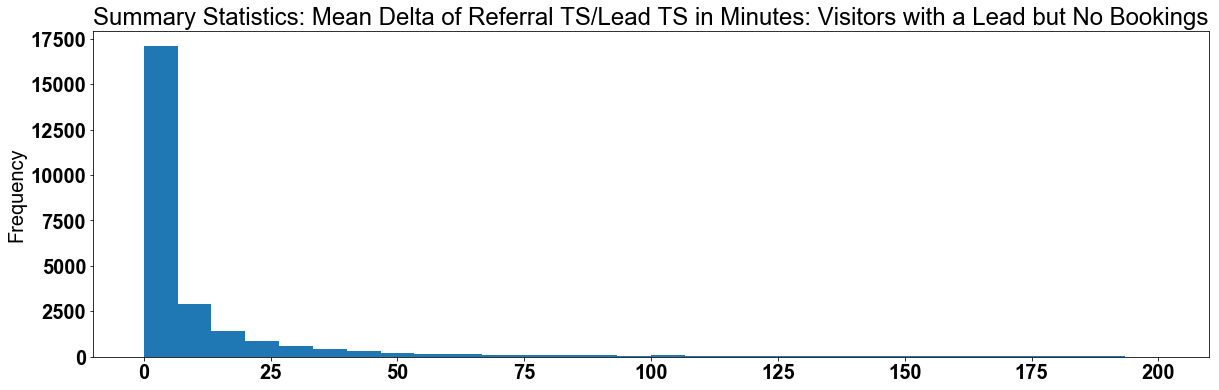

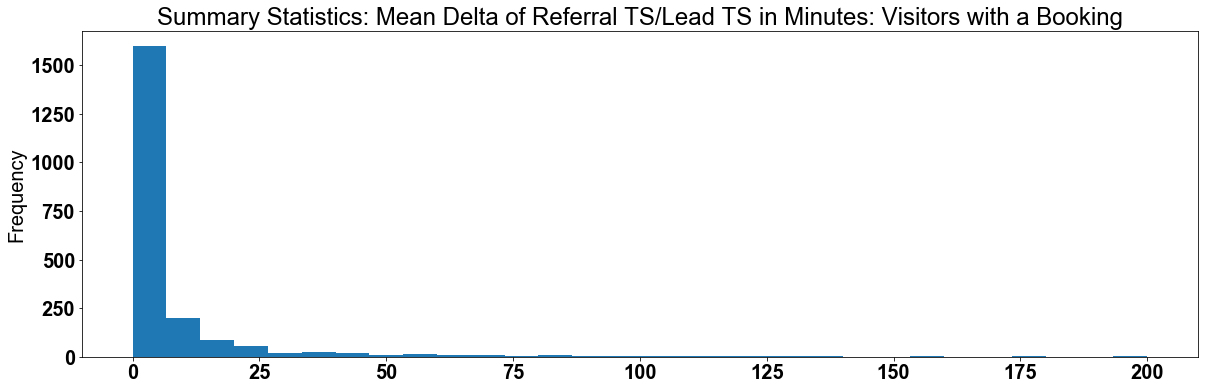

In [67]:
summaryStatsReferralLeadBooking(df_good_ids, 'referral_to_lead_ts_mins_mean', 
                                'Summary Statistics: Mean Delta of Referral TS/Lead TS in Minutes',
                               max_val=200, include_referrals=False)

### check-in exploration

How far in the future are visitors booking? Is there a difference in these windows between those who book and those who do not?

In [68]:
# Add column for difference in days between referral check-in and time stamp 

# Save ts as a date-only field (with time dropped)
df_good_ids['referral_date'] = pd.DatetimeIndex(df_good_ids['ts']).normalize()

# Find difference between referral date and check in
df_good_ids['ts_to_check-in'] = (df_good_ids['check-in'] - df_good_ids['referral_date']).dt.days

# Check values
df_good_ids[['ts', 'check-in', 'ts_to_check-in']].head()

,ts,check-in,ts_to_check-in
0,2017-10-18 03:40:40.345,2017-11-19,32.0
1,2017-10-16 15:33:39.130,2017-10-20,4.0
2,2017-10-16 15:33:43.648,2017-10-20,4.0
3,2017-10-16 15:56:15.163,2017-10-20,4.0
4,2017-10-16 16:21:07.660,2017-10-20,4.0


In [69]:
# Get overall summary statistics for referral to lead ts
summaryStats(df_good_ids['ts_to_check-in'], 
             'Overall Summary Statistics: Days between Referral TS and Referral Check-In Date')


-- Overall Summary Statistics: Days between Referral TS and Referral Check-In Date --

Mean:  35.062
Standard Deviation:  125.598
Median:  11.0
Max:  1514.0
Min:  -36524.0


Notice there are __negative__ values, meaning that people are indicating check-in dates in the past.

In [70]:
# Add min, max, mean of ts_to_check-in for each visitor, as well as unique count of check-in values

# Min
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['ts_to_check-in'].min(), 
                               on='visitor-id', rsuffix='_min')
# Max
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['ts_to_check-in'].max(), 
                               on='visitor-id', rsuffix='_max')
# Mean
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['ts_to_check-in'].mean(), 
                               on='visitor-id', rsuffix='_mean')

# Range of values
df_good_ids['ts_to_check-in_range'] = df_good_ids['ts_to_check-in_max'] - df_good_ids['ts_to_check-in_min'] 

# Number of unique values
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['check-in'].nunique(dropna=True), 
                                on='visitor-id', rsuffix='_unique_values')

/anaconda3/envs/PY3/lib/python3.6/site-packages/pandas/core/groupby.py:3154: FutureWarning: In the future, NAT != NAT will be True rather than False.
  inc = np.r_[1, val[1:] != val[:-1]]


In [71]:
# Check for negative values for check-in
print("Number of visitors with a negative difference between ts and check-in dates:", 
      len(df_good_ids['visitor-id'][df_good_ids['ts_to_check-in_mean'] < 0].unique())) 
print("Percentage of visitors with a negative difference between ts and check-in dates:", 
      round(len(df_good_ids['visitor-id'][df_good_ids['ts_to_check-in_mean'] < 0].unique()) / visitor_count * 100, 2), '%')
print("Number of visitors with with a negative difference between ts and check-in dates who also had a booking:",
      len(df_good_ids['visitor-id'][(df_good_ids['ts_to_check-in_mean'] < 0) & 
                                    (df_good_ids['booking_visitor-id_count']>0)].unique()))
print("Percentage of visitors with a negative difference between ts and check-in dates who also had a booking:",
      round(len(df_good_ids['visitor-id'][(df_good_ids['ts_to_check-in_mean'] < 0) & 
                                          (df_good_ids['booking_visitor-id_count']>0)].unique()) / 
      len(df_good_ids['visitor-id'][df_good_ids['ts_to_check-in_mean'] < 0].unique()) * 100, 2), '%')
print("Percentage of visitors with a no difference between ts and check-in dates who also had a booking:",
      round(len(df_good_ids['visitor-id'][(df_good_ids['ts_to_check-in_mean'] == 0) & 
                                          (df_good_ids['booking_visitor-id_count']>0)].unique()) / 
      len(df_good_ids['visitor-id'][df_good_ids['ts_to_check-in_mean'] == 0].unique()) * 100, 2), '%')
print("Percentage of visitors with a positive difference between ts and check-in dates who also had a booking:",
      round(len(df_good_ids['visitor-id'][(df_good_ids['ts_to_check-in_mean'] > 0) & 
                                          (df_good_ids['booking_visitor-id_count']>0)].unique()) / 
      len(df_good_ids['visitor-id'][df_good_ids['ts_to_check-in_mean'] > 0].unique()) * 100, 2), '%')

Number of visitors with a negative difference between ts and check-in dates: 23489
Percentage of visitors with a negative difference between ts and check-in dates: 2.71 %
Number of visitors with with a negative difference between ts and check-in dates who also had a booking: 19
Percentage of visitors with a negative difference between ts and check-in dates who also had a booking: 0.08 %
Percentage of visitors with a no difference between ts and check-in dates who also had a booking: 0.13 %
Percentage of visitors with a positive difference between ts and check-in dates who also had a booking: 0.28 %


_Observation_: Visitors with check-in dates in past at referral are only around 30% as likely to book than a visitor with a check-in date in the future

### Summary Statistics: Mean Delta for referral ts to referral check-in date for visitors with:
1. no lead or booking
2. a lead but no booking
3. a booking

_Observations_: On average, the __booking__ group has a shorter window from referral timestamp to check-in date: compare 26.55 days with 36.43 days, almost a 10-day difference compared with the __lead only__ group.


-- Summary Statistics: Mean Delta in Days for Referral TS/Referral Check-in: Visitors with Referrals Only --

Mean:  36.082
Standard Deviation:  113.665
Median:  12.0
Max:  1124.0
Min:  -36524.0

-- Summary Statistics: Mean Delta in Days for Referral TS/Referral Check-in: Visitors with a Lead but No Bookings --

Mean:  36.433
Standard Deviation:  64.061
Median:  14.333333333333334
Max:  690.0
Min:  -559.0

-- Summary Statistics: Mean Delta in Days for Referral TS/Referral Check-in: Visitors with a Booking --

Mean:  26.547
Standard Deviation:  47.134
Median:  11.0
Max:  357.0
Min:  -224.0


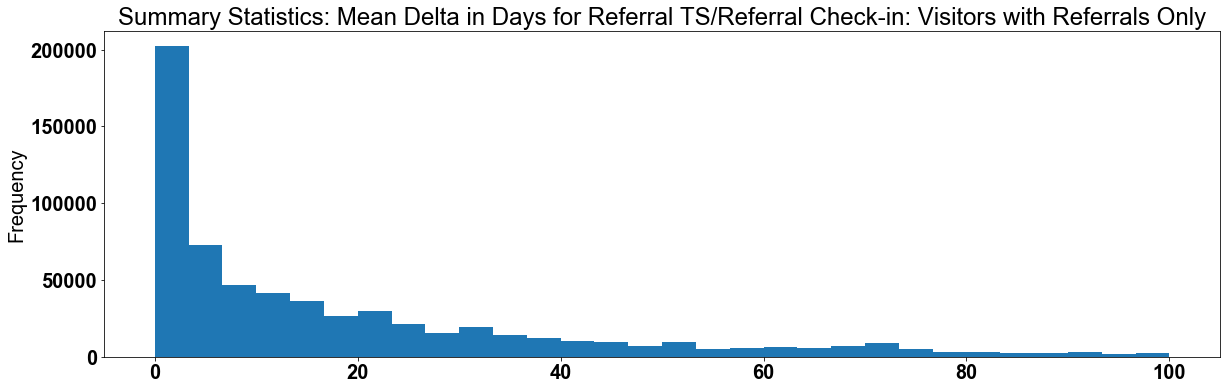

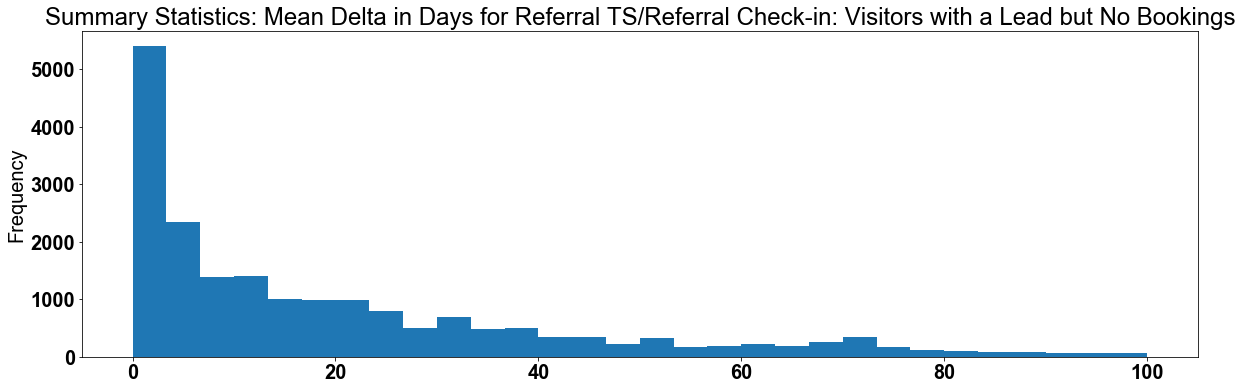

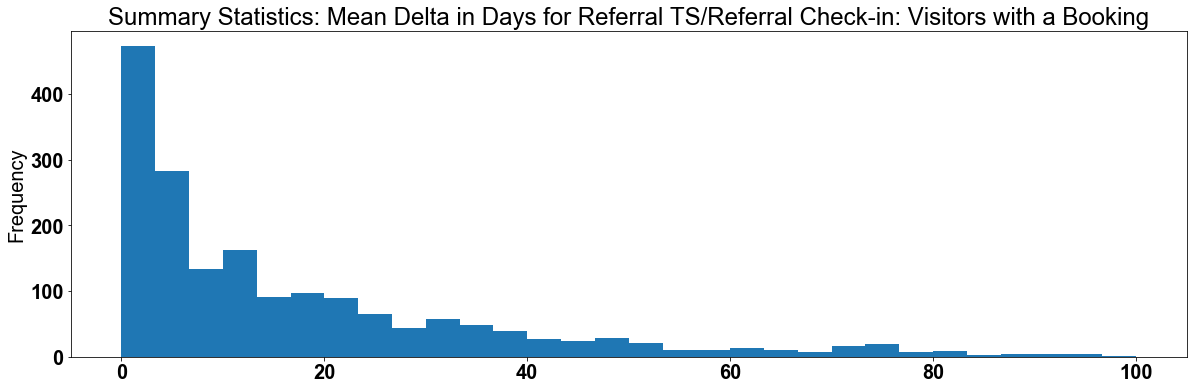

In [72]:
summaryStatsReferralLeadBooking(df_good_ids, 'ts_to_check-in_mean', 
                                'Summary Statistics: Mean Delta in Days for Referral TS/Referral Check-in',
                               max_val=100)

### location-tid exploration

How many locations are visitors selecting? Is the number of sites correlated to bookings?

In [73]:
# Exploration of null values for location-tid

print("Number of records with no location-tid:", 
      len(df_good_ids[df_good_ids['location-tid'].isnull()]))
print("Percentage of records with no location-tid:", 
      round(len(df_good_ids[df_good_ids['location-tid'].isnull()]) / len(df_good_ids) * 100, 2))
print("Number of records with only referrals and no location-tid:",
     len(df_good_ids[(df_good_ids['location-tid'].isnull()) &
                    (df_good_ids['lead_visitor-id'].isnull()) &
                     (df_good_ids['booking_visitor-id'].isnull())]))
print("Percentage of records with referrals and no lead/bookings that have no location-tid:",
     round(len(df_good_ids[(df_good_ids['location-tid'].isnull()) &
                    (df_good_ids['lead_visitor-id'].isnull()) &
                     (df_good_ids['booking_visitor-id'].isnull())]) / len(df_good_ids[(df_good_ids['lead_visitor-id'].isnull()) &
                     (df_good_ids['booking_visitor-id'].isnull())]) * 100, 2))
print("Percentage of records that have no location-tid that also have no lead/booking:",
      round(len(df_good_ids[(df_good_ids['location-tid'].isnull()) &
                    (df_good_ids['lead_visitor-id'].isnull()) &
                     (df_good_ids['booking_visitor-id'].isnull())]) / len(df_good_ids[df_good_ids['location-tid'].isnull()]) * 100, 
      2))

Number of records with no location-tid: 38666
Percentage of records with no location-tid: 2.76
Number of records with only referrals and no location-tid: 38638
Percentage of records with referrals and no lead/bookings that have no location-tid: 2.82
Percentage of records that have no location-tid that also have no lead/booking: 99.93


_Observation_: Most records have a location-tid, but of those that do not, __99.93%__ of them have no lead/booking associated with them.

In [74]:
# Get cumulative counts of unique location-tids by visitor

# Arrange df_good_ids by visitor-id and ts
df_good_ids.sort_values(by=['visitor-id', 'ts'], inplace=True)

# Add rownames to df
df_good_ids['id'] = df_good_ids.index

# Subset to include first record for each visitor
first_record = df_good_ids[df_good_ids['cumulative_referral_count']==1]

# Subset first records for those with null value for location-tid and those that do not, as each
# will require a different approach
first_record_no_loc = first_record[first_record['location-tid'].isnull()]
first_record_with_loc = first_record[first_record['location-tid'].notnull()]

# Join rest of data to first_record dfs
first_record_no_loc = df_good_ids[df_good_ids['visitor-id'].isin(first_record_no_loc['visitor-id'])]
first_record_with_loc = df_good_ids[df_good_ids['visitor-id'].isin(first_record_with_loc['visitor-id'])]

# Order by id
first_record_no_loc = first_record_no_loc.sort_values(by=['visitor-id', 'ts'])
first_record_with_loc = first_record_with_loc.sort_values(by=['visitor-id', 'ts'])

# Check that the number of rows matches df_good_ids
len(first_record_no_loc) + len(first_record_with_loc) == len(df_good_ids)

True

In [75]:
# Cumulative counts of unique location-tid by visitor-id

# Reset index for both data frames
first_record_no_loc.reset_index(inplace=True)
first_record_with_loc.reset_index(inplace=True)
first_record_no_loc['id'] = first_record_no_loc.index
first_record_with_loc['id'] = first_record_with_loc.index

# Get cumulative counts
unique_loc_no_loc = first_record_no_loc[['visitor-id', 'location-tid']].drop_duplicates().groupby('visitor-id').cumcount()
unique_loc_no_loc = unique_loc_no_loc.reindex(first_record_no_loc.id).ffill().to_frame()
unique_loc_no_loc.reset_index(level=0, inplace=True)
unique_loc_no_loc.rename(columns={1: 'id', 0:'cumulative_location-tid_count'}, inplace=True)

unique_loc_with_loc = first_record_with_loc[first_record_with_loc['location-tid'].notnull()][['visitor-id', 'location-tid']].drop_duplicates().groupby('visitor-id').cumcount() + 1
unique_loc_with_loc = unique_loc_with_loc.reindex(first_record_with_loc.id).ffill().to_frame()
unique_loc_with_loc.reset_index(level=0, inplace=True)
unique_loc_with_loc.rename(columns={1: 'id', 0:'cumulative_location-tid_count'}, inplace=True)

# Merge to dataframes
first_record_no_loc = first_record_no_loc.merge(unique_loc_no_loc, how='left', on='id')
first_record_with_loc = first_record_with_loc.merge(unique_loc_with_loc, how='left', on='id')

# Join dataframes together, overwriting df_good_ids
df_good_ids = pd.concat([first_record_no_loc, first_record_with_loc])

# Remove id columns
df_good_ids = df_good_ids.drop(['id'], axis=1)

# Check dataframe
df_good_ids[['visitor-id', 'location-tid', 'cumulative_location-tid_count']].head(20)

,visitor-id,location-tid,cumulative_location-tid_count
0,12fa7e47-5841-4fed-bb28-248e334417f0,NaN,0.0
1,157960d0-1f66-42c9-be6b-c61816ae331a,NaN,0.0
2,1f156ce9-2655-4e7c-a1ea-aab3be62f4bb,NaN,0.0
3,1f156ce9-2655-4e7c-a1ea-aab3be62f4bb,zaabp5MK847Kh2hBiLzm4oG,1.0
4,1f156ce9-2655-4e7c-a1ea-aab3be62f4bb,1KsRCiG4S04s5cO05g9krVMw,2.0
5,1f156ce9-2655-4e7c-a1ea-aab3be62f4bb,1KsRCiG4S04s5cO05g9krVMw,2.0
6,1f156ce9-2655-4e7c-a1ea-aab3be62f4bb,1KsRCiG4S04s5cO05g9krVMw,2.0
7,23629230-b3af-4ffb-aca1-25ca6d8551ed,NaN,0.0
8,237aac78-4eca-43bd-9004-555869547416,NaN,0.0
9,3758b3cd-d742-4ba8-83e7-c48a88bc1da2,NaN,0.0


In [76]:
# Add summative counts of unique values for location-tid

df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['cumulative_location-tid_count'].max(), 
                               on='visitor-id', rsuffix='_max')

# Rename column
df_good_ids.rename(columns={'cumulative_location-tid_count_max':'location-tid_count'}, inplace=True)

### Summary Statistics: Number of unique location-tid values for visitors with:
1. no lead or booking
2. a lead but no booking
3. a booking

_Observations_: Mean count of unique locations does not vary much between groups, but the __booking__ group has the highest mean count (1.49). This is influenced in part by the fact that almost all of the records with no location-tid are in the referral-only group.


-- Summary Statistics: Unique location-tid Values: Visitors with Referrals Only --

Mean:  1.109
Standard Deviation:  0.571
Median:  1.0
Max:  96.0
Min:  0.0

-- Summary Statistics: Unique location-tid Values: Visitors with a Lead but No Bookings --

Mean:  1.196
Standard Deviation:  0.608
Median:  1.0
Max:  16.0
Min:  0.0

-- Summary Statistics: Unique location-tid Values: Visitors with a Booking --

Mean:  1.246
Standard Deviation:  0.966
Median:  1.0
Max:  21.0
Min:  0.0


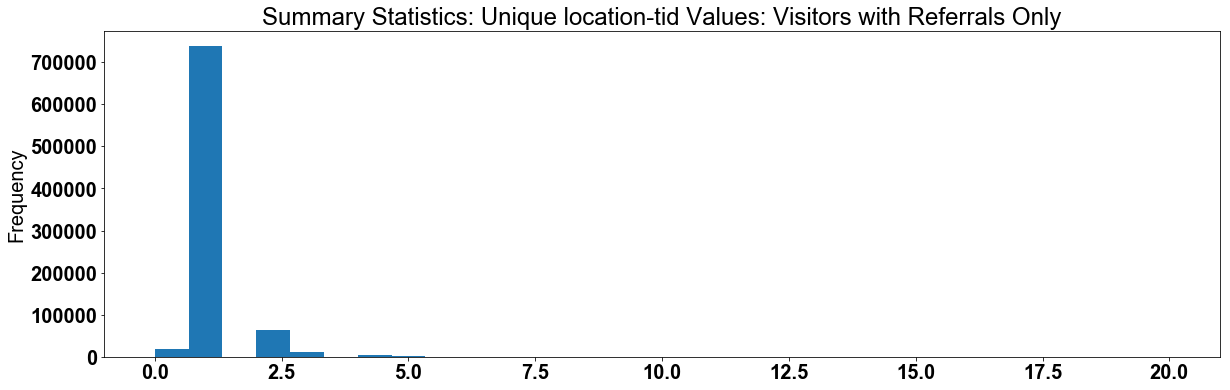

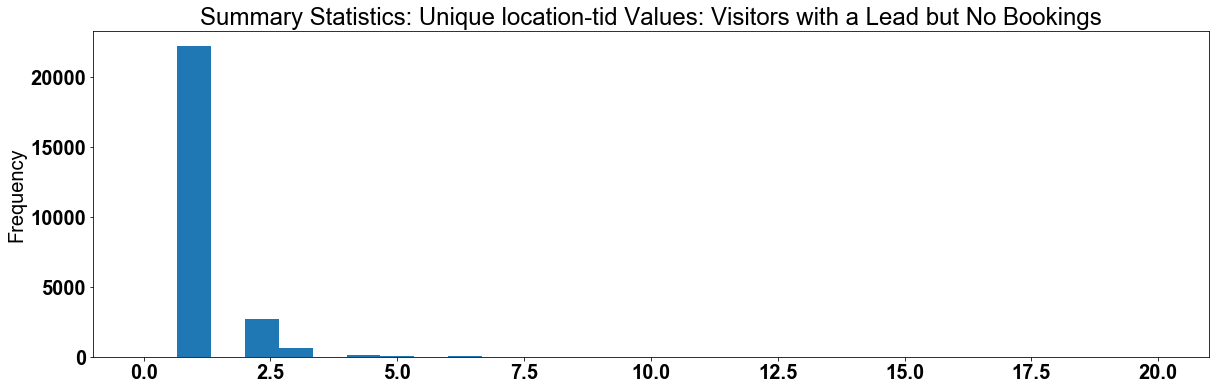

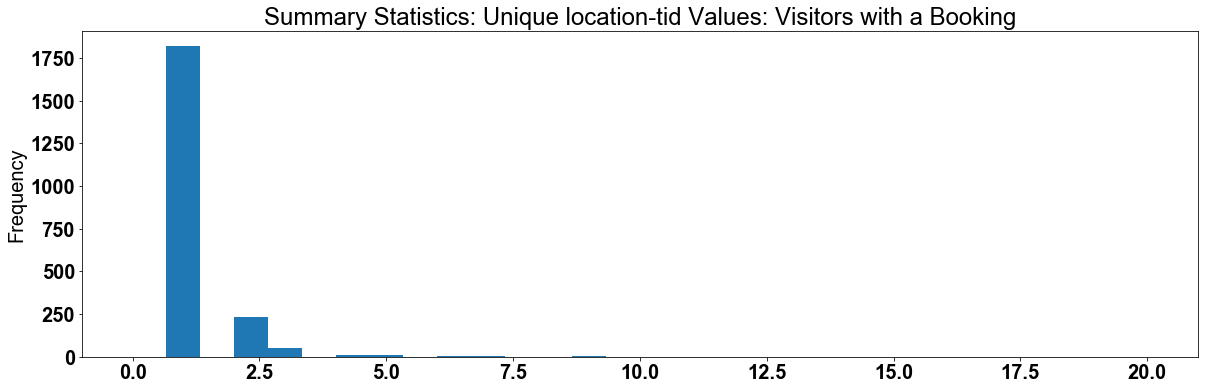

In [77]:
summaryStatsReferralLeadBooking(df_good_ids, 'location-tid_count', 
                                'Summary Statistics: Unique location-tid Values', max_val=20)

### udicode exploration

How many hotels are visitors selecting? Is the number of hotels correlated to bookings?

In [78]:
# Exploration of null values for udicode

print("Number of records with no udicode:", 
      len(df_good_ids[df_good_ids['udicode'].isnull()]))
print("Percentage of records with no udicode:", 
      round(len(df_good_ids[df_good_ids['udicode'].isnull()]) / len(df_good_ids) * 100, 2))
print("Number of records with only referrals and no udicode:",
     len(df_good_ids[(df_good_ids['udicode'].isnull()) &
                    (df_good_ids['lead_visitor-id'].isnull()) &
                     (df_good_ids['booking_visitor-id'].isnull())]))
print("Percentage of records with referrals and no lead/bookings that have no location-tid:",
     round(len(df_good_ids[(df_good_ids['udicode'].isnull()) &
                    (df_good_ids['lead_visitor-id'].isnull()) &
                     (df_good_ids['booking_visitor-id'].isnull())]) / len(df_good_ids[(df_good_ids['lead_visitor-id'].isnull()) &
                     (df_good_ids['booking_visitor-id'].isnull())]) * 100, 2))
print("Percentage of records that have no udicode that also have no lead/booking:",
      round(len(df_good_ids[(df_good_ids['udicode'].isnull()) &
                    (df_good_ids['lead_visitor-id'].isnull()) &
                     (df_good_ids['booking_visitor-id'].isnull())]) / len(df_good_ids[df_good_ids['udicode'].isnull()]) * 100, 
      2))

Number of records with no udicode: 702409
Percentage of records with no udicode: 50.22
Number of records with only referrals and no udicode: 692092
Percentage of records with referrals and no lead/bookings that have no location-tid: 50.52
Percentage of records that have no udicode that also have no lead/booking: 98.53


_Observation_: About half of records have no udicode, and __98.53%__ of records that have no udicode also have no lead/booking associated with them.

In [79]:
# Get cumulative counts of unique udicode by visitor

# Arrange df_good_ids by visitor-id and ts
df_good_ids.sort_values(by=['visitor-id', 'ts'], inplace=True)

# Add rownames to df
df_good_ids['id'] = df_good_ids.index

# Subset first records for those with null value for location-tid and those that do not, as each
# will require a different approach
first_record_no_udi = first_record[first_record['udicode'].isnull()]
first_record_with_udi = first_record[first_record['udicode'].notnull()]

# Join rest of data to first_record dfs
first_record_no_udi = df_good_ids[df_good_ids['visitor-id'].isin(first_record_no_udi['visitor-id'])]
first_record_with_udi = df_good_ids[df_good_ids['visitor-id'].isin(first_record_with_udi['visitor-id'])]

# Order by id
first_record_no_udi = first_record_no_udi.sort_values(by=['visitor-id', 'ts'])
first_record_with_udi = first_record_with_udi.sort_values(by=['visitor-id', 'ts'])

# Check that the number of rows matches df_good_ids
len(first_record_no_udi) + len(first_record_with_udi) == len(df_good_ids)

True

In [80]:
# Cumulative counts of unique udicode by visitor-id

# Reset index for both data frames
first_record_no_udi.reset_index(inplace=True)
first_record_with_udi.reset_index(inplace=True)
first_record_no_udi['id'] = first_record_no_udi.index
first_record_with_udi['id'] = first_record_with_udi.index

# Get cumulative counts
unique_udi_no_udi = first_record_no_udi[['visitor-id', 'udicode']].drop_duplicates().groupby('visitor-id').cumcount()
unique_udi_no_udi = unique_udi_no_udi.reindex(first_record_no_udi.id).ffill().to_frame()
unique_udi_no_udi.reset_index(level=0, inplace=True)
unique_udi_no_udi.rename(columns={1: 'id', 0:'cumulative_udicode_count'}, inplace=True)

unique_udi_with_udi = first_record_with_udi[first_record_with_udi['location-tid'].notnull()][['visitor-id', 'udicode']].drop_duplicates().groupby('visitor-id').cumcount() + 1
unique_udi_with_udi = unique_udi_with_udi.reindex(first_record_with_udi.id).ffill().to_frame()
unique_udi_with_udi.reset_index(level=0, inplace=True)
unique_udi_with_udi.rename(columns={1: 'id', 0:'cumulative_udicode_count'}, inplace=True)

# Merge to dataframes
first_record_no_udi = first_record_no_udi.merge(unique_udi_no_udi, how='left', on='id')
first_record_with_udi = first_record_with_udi.merge(unique_udi_with_udi, how='left', on='id')

# Join dataframes together, overwriting df_good_ids
df_good_ids = pd.concat([first_record_no_udi, first_record_with_udi])

# Remove id columns
df_good_ids = df_good_ids.drop(['id'], axis=1)

# Check dataframe
df_good_ids[['visitor-id', 'udicode', 'cumulative_udicode_count']].head(20)

,visitor-id,udicode,cumulative_udicode_count
0,00b823ad-1206-439e-a634-2b64fd0c5789,NaN,0.0
1,00b823ad-1206-439e-a634-2b64fd0c5789,NaN,0.0
2,00b823ad-1206-439e-a634-2b64fd0c5789,NaN,0.0
3,00b823ad-1206-439e-a634-2b64fd0c5789,NaN,0.0
4,00b823ad-1206-439e-a634-2b64fd0c5789,NaN,0.0
5,00b823ad-1206-439e-a634-2b64fd0c5789,NaN,0.0
6,00b823ad-1206-439e-a634-2b64fd0c5789,66c1d55050e44c8d9e20b215,1.0
7,00b823ad-1206-439e-a634-2b64fd0c5789,NaN,1.0
8,00b823ad-1206-439e-a634-2b64fd0c5789,4LWSO0G4S04s6DI05g9krVMw,2.0
9,00b823ad-1206-439e-a634-2b64fd0c5789,4LWSO0G4S04s6DI05g9krVMw,2.0


In [81]:
# Add summative counts of unique values for udicode

df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['cumulative_udicode_count'].max(), 
                               on='visitor-id', rsuffix='_max')

# Rename column
df_good_ids.rename(columns={'cumulative_udicode_count_max':'udicode_count'}, inplace=True)

### Summary Statistics: Number of unique udi values for visitors with:
1. no lead or booking
2. a lead but no booking
3. a booking

_Observations_: As with location-tids, the mean count of unique udicodes increases for the __lead__ group and again for the __booking__ group; however, the means are fairly consistent for the __lead__ and __booking__ groups, both around 1.


-- Summary Statistics: Unique udicode Values: Visitors with Referrals Only --

Mean:  0.684
Standard Deviation:  0.855
Median:  1.0
Max:  121.0
Min:  0.0

-- Summary Statistics: Unique udicode Values: Visitors with a Lead but No Bookings --

Mean:  0.956
Standard Deviation:  0.993
Median:  1.0
Max:  22.0
Min:  0.0

-- Summary Statistics: Unique udicode Values: Visitors with a Booking --

Mean:  1.029
Standard Deviation:  1.075
Median:  1.0
Max:  21.0
Min:  0.0


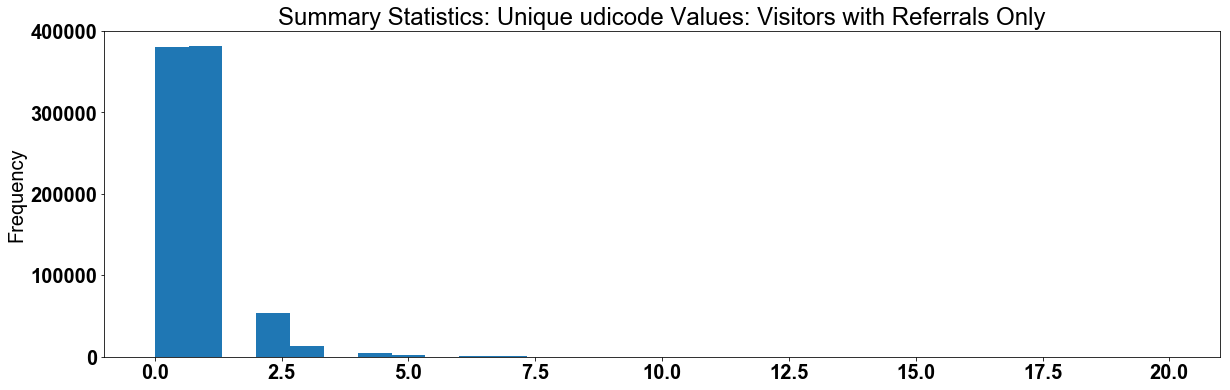

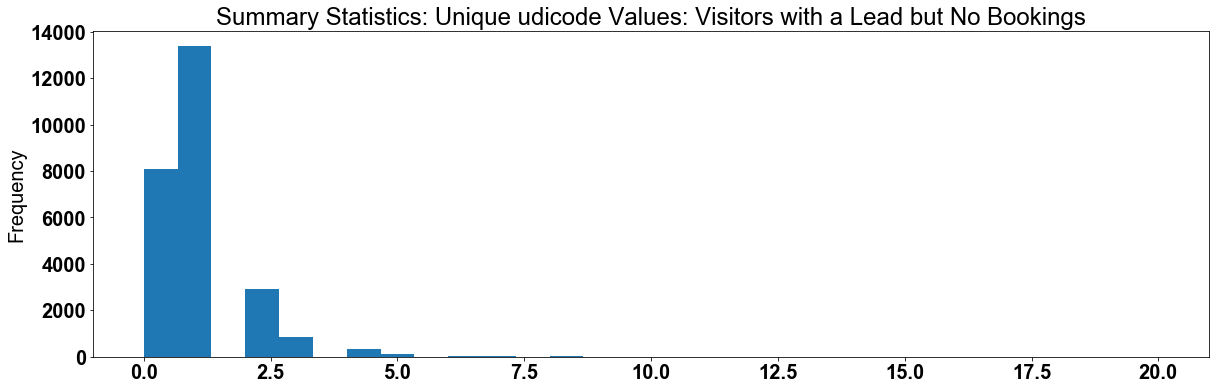

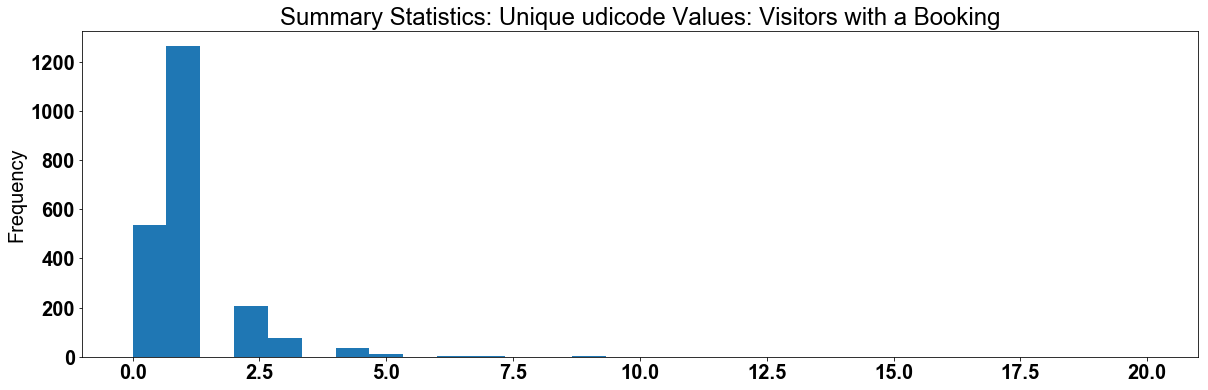

In [82]:
summaryStatsReferralLeadBooking(df_good_ids, 'udicode_count', 
                                'Summary Statistics: Unique udicode Values', max_val=20)

### Length of time between first ts for a visitor and ts for current record

In [83]:
# Subset first_record to include just visitor-id and timestamp
first_ts = first_record[['visitor-id', 'ts']]

# Change name of column
first_ts =  first_ts.rename(columns={'ts':'first_ts'})

# Join to df_good_ids
df_good_ids = df_good_ids.merge(first_ts, how='outer')

# Get difference between first time stamp and current time stamp
df_good_ids['time_from_first_record_mins'] = df_good_ids['ts'] - df_good_ids['first_ts']

# Change time value to minutes
df_good_ids['time_from_first_record_mins'] = df_good_ids['time_from_first_record_mins'].dt.seconds / 60

# Check df_good_ids
df_good_ids.head(5)

,level_0,index,visitor-id,event-id,ts,partner-code,udicode,location-tid,check-in,check-out,lead_visitor-id,lead_event-id,lead_ts,lead_rate-partner,booking_visitor-id,booking_event-id,booking_ts,booking_rate-partner,booking_total-amount,booking_currency,booking_nights,booking_rooms,booking_check-in,booking_check-out,referral_visitor-id_count,lead_visitor-id_count,booking_visitor-id_count,cumulative_referral_count,cumulative_lead_count,cumulative_booking_count,prior_booking_count,cumulative_referral_hotel_count,cumulative_lead_hotel_count,cumulative_booking_hotel_count,referral_hotel_count,lead_hotel_count,booking_hotel_count,referral_to_lead_ts_mins,referral_to_lead_ts_mins_mean,referral_to_lead_ts_mins_median,referral_to_lead_ts_mins_min,referral_to_lead_ts_mins_max,referral_to_lead_ts_mins_range,referral_date,ts_to_check-in,ts_to_check-in_min,ts_to_check-in_max,ts_to_check-in_mean,ts_to_check-in_range,check-in_unique_values,cumulative_location-tid_count,location-tid_count,cumulative_udicode_count,udicode_count,first_ts,time_from_first_record_mins
0,1,1,00b823ad-1206-439e-a634-2b64fd0c5789,59e4d153-e2f1-4f0e-a67e-dfec321319b9,2017-10-16 15:33:39.130,HLTN,NaN,QPo9d9W3wEmJDKTvD1eXqIf,2017-10-20,2017-10-23,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,18,NaN,NaN,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-16,4.0,4.0,163.0,124.611111,159.0,4,1.0,6.0,0.0,4.0,2017-10-16 15:33:39.130,0.000000
1,2,2,00b823ad-1206-439e-a634-2b64fd0c5789,59e4d157-0a48-4285-ab89-26ea8d66b4e4,2017-10-16 15:33:43.648,HLTN,NaN,QPo9d9W3wEmJDKTvD1eXqIf,2017-10-20,2017-10-23,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,18,NaN,NaN,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-16,4.0,4.0,163.0,124.611111,159.0,4,1.0,6.0,0.0,4.0,2017-10-16 15:33:39.130,0.066667
2,3,3,00b823ad-1206-439e-a634-2b64fd0c5789,59e4d69f-5732-4507-85df-7b36d39d925b,2017-10-16 15:56:15.163,HLTN,NaN,0zuhfsG4T04s5cO05g9krVMw,2017-10-20,2017-10-23,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,18,NaN,NaN,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-16,4.0,4.0,163.0,124.611111,159.0,4,2.0,6.0,0.0,4.0,2017-10-16 15:33:39.130,22.600000
3,4,4,00b823ad-1206-439e-a634-2b64fd0c5789,59e4dc73-03b4-4d55-a335-8fe509540c31,2017-10-16 16:21:07.660,HLTN,NaN,QPo9d9W3wEmJDKTvD1eXqIf,2017-10-20,2017-10-23,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,18,NaN,NaN,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-16,4.0,4.0,163.0,124.611111,159.0,4,2.0,6.0,0.0,4.0,2017-10-16 15:33:39.130,47.466667
4,5,5,00b823ad-1206-439e-a634-2b64fd0c5789,59e503f0-e5ce-4601-9503-0cacf93efa5f,2017-10-16 19:09:36.883,HLTN,NaN,2dgRdYG4S04s5cO05g9krVMw,2018-03-23,2018-03-30,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,18,NaN,NaN,5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-16,158.0,4.0,163.0,124.611111,159.0,4,3.0,6.0,0.0,4.0,2017-10-16 15:33:39.130,215.950000


In [84]:
# Add mean, median, max, min, and range of time_from_first_record_mins for each visitor

# Mean
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['time_from_first_record_mins'].mean(), 
                               on='visitor-id', rsuffix='_mean')

# Median
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['time_from_first_record_mins'].median(), 
                               on='visitor-id', rsuffix='_median')

# Min
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['time_from_first_record_mins'].min(), 
                               on='visitor-id', rsuffix='_min')

# Max
df_good_ids = df_good_ids.join(df_good_ids.groupby('visitor-id')['time_from_first_record_mins'].max(), 
                               on='visitor-id', rsuffix='_max')

# Range of values
df_good_ids['time_from_first_record_mins_range'] = df_good_ids['time_from_first_record_mins_max'] - df_good_ids['time_from_first_record_mins_min'] 

### Summary Statistics: Mean time between first record and current record for visitors with:
1. no lead or booking
2. a lead but no booking
3. a booking

_Observations_: The median number of minutes between first record and current record is 0 for all three groups, but the means are significantly above this: 19.2 for the __referral__ group, 32.7 for the __lead__ group, and 39.4 for the __booking__ group. There are siginficant outliers in each set, as observed by the max values for each group.


-- Summary Statistics: Mean Time between First Record and Current Record in Minutes: Visitors with Referrals Only --

Mean:  19.225
Standard Deviation:  96.876
Median:  0.0
Max:  1318.0
Min:  0.0

-- Summary Statistics: Mean Time between First Record and Current Record in Minutes: Visitors with a Lead but No Bookings --

Mean:  32.67
Standard Deviation:  123.884
Median:  0.0
Max:  1206.03333333
Min:  0.0

-- Summary Statistics: Mean Time between First Record and Current Record in Minutes: Visitors with a Booking --

Mean:  39.441
Standard Deviation:  135.239
Median:  0.0
Max:  1116.54722222
Min:  0.0


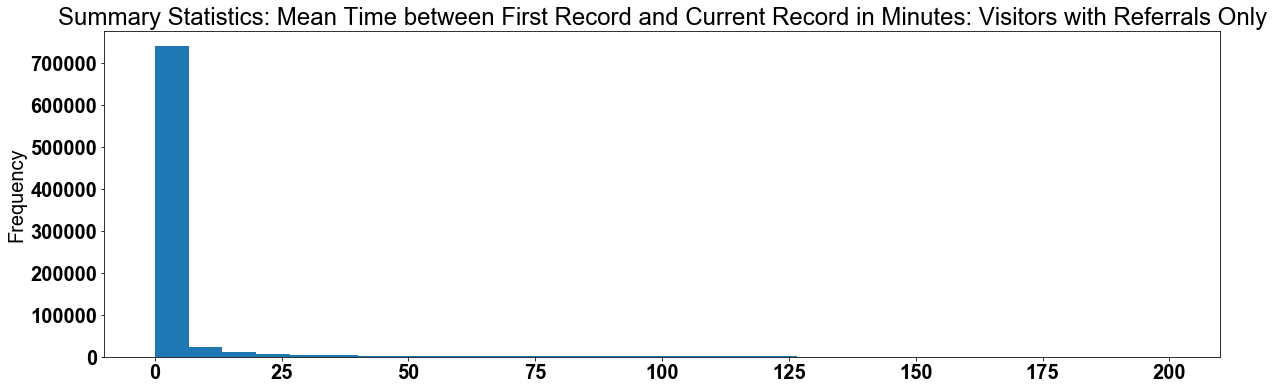

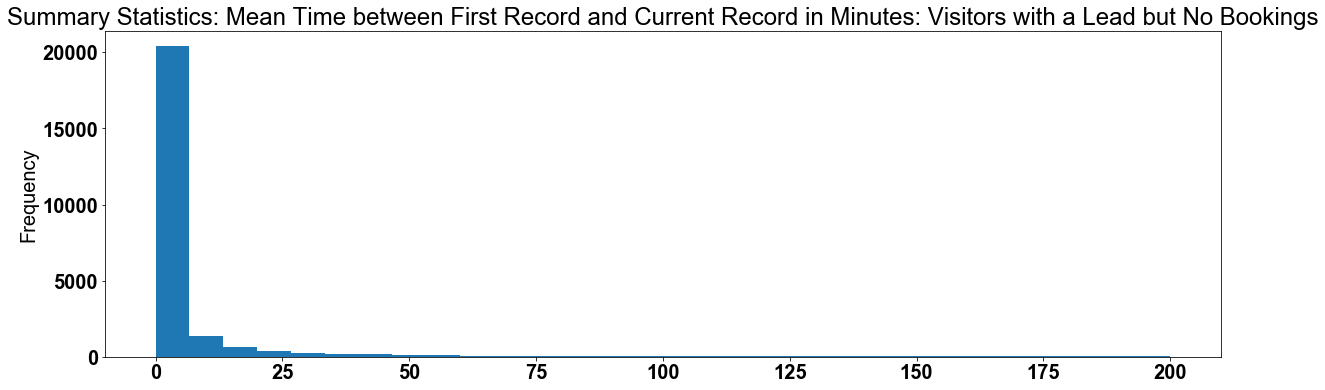

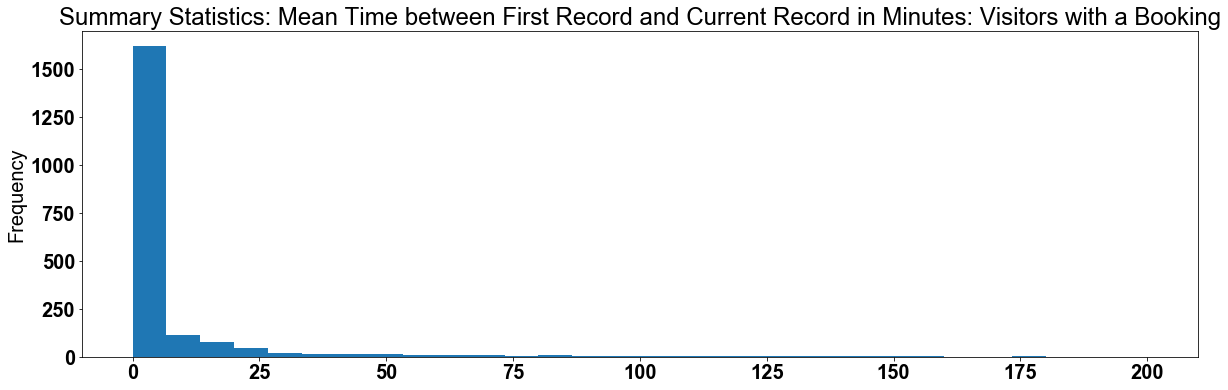

In [85]:
summaryStatsReferralLeadBooking(df_good_ids, 'time_from_first_record_mins_mean', 
                                'Summary Statistics: Mean Time between First Record and Current Record in Minutes', 
                                max_val=200)

### ts day of the week

In [86]:
# Add day of week for timestamp
df_good_ids['ts_day_of_week'] = df_good_ids['ts'].dt.weekday_name

Text(0.5,1,'Booking Group: Timestamp by Day of Week')

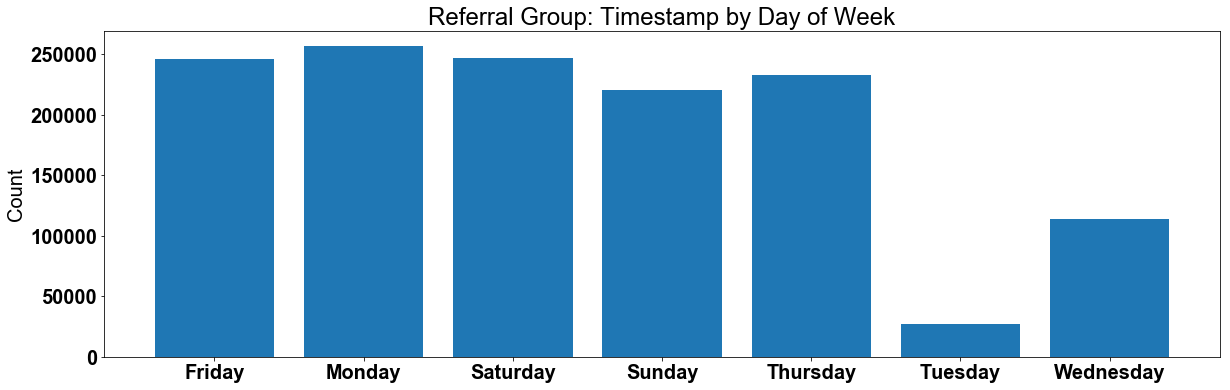

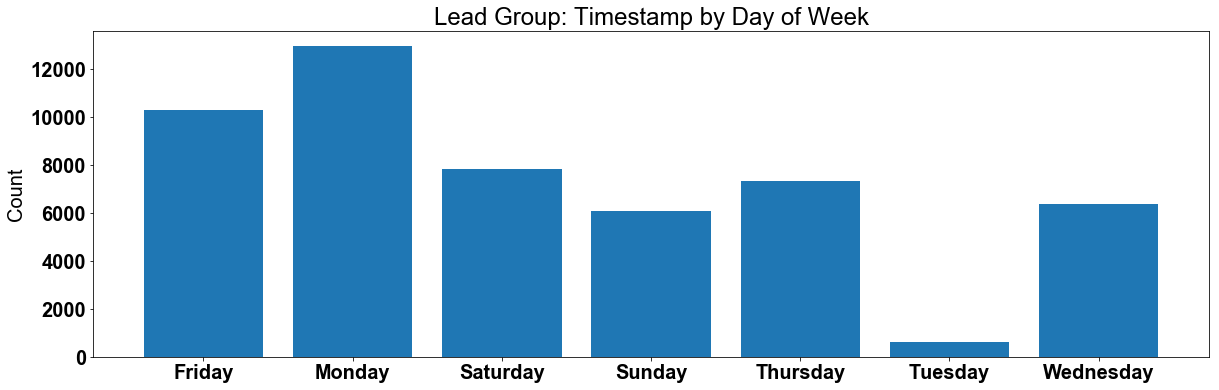

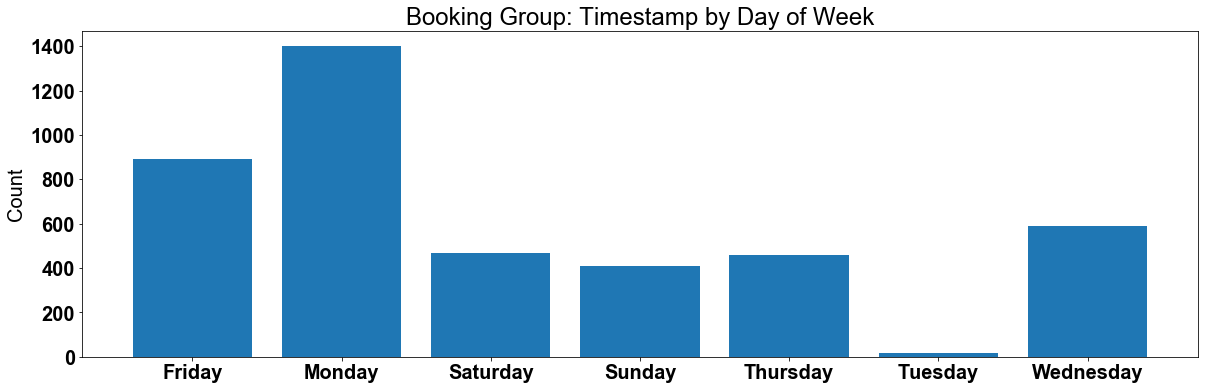

In [87]:
# Plot distribution of days of the week for referral only, lead, and booking groups
df_referral = df_good_ids[(df_good_ids['lead_visitor-id_count'].isnull()) & 
                     (df_good_ids['booking_visitor-id_count'].isnull())]

referral_ts_weekday_freq = pd.crosstab(index=df_referral['ts_day_of_week'], columns='day_of_week')

df_lead = df_good_ids[(df_good_ids['lead_visitor-id_count'].notnull()) & 
                     (df_good_ids['booking_visitor-id_count'].isnull())]

lead_ts_weekday_freq = pd.crosstab(index=df_lead['ts_day_of_week'], columns='day_of_week')

df_booking  = df_good_ids[(df_good_ids['lead_visitor-id_count'].notnull()) & 
                     (df_good_ids['booking_visitor-id_count'].notnull())]

booking_ts_weekday_freq = pd.crosstab(index=df_booking['ts_day_of_week'], columns=['day_of_week'])

weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Referral group plot    
plt.figure(1)
plt.figure(figsize=(20,6))
plt.bar(weekdays, referral_ts_weekday_freq.day_of_week)
plt.ylabel('Count')
plt.title("Referral Group: Timestamp by Day of Week")

# Lead group plot
plt.figure(2)
plt.figure(figsize=(20,6))
plt.bar(weekdays, lead_ts_weekday_freq.day_of_week)
plt.ylabel('Count')
plt.title("Lead Group: Timestamp by Day of Week")

# Booking group plot
plt.figure(3)
plt.figure(figsize=(20,6))
plt.bar(weekdays, booking_ts_weekday_freq.day_of_week)
plt.ylabel('Count')
plt.title("Booking Group: Timestamp by Day of Week")

### ts hour of the day

In [88]:
# Add hour of the day for timestamp
df_good_ids['ts_hour_of_day'] = df_good_ids['ts'].dt.hour

Text(0.5,1,'Booking Group: Timestamp by Hour of Day')

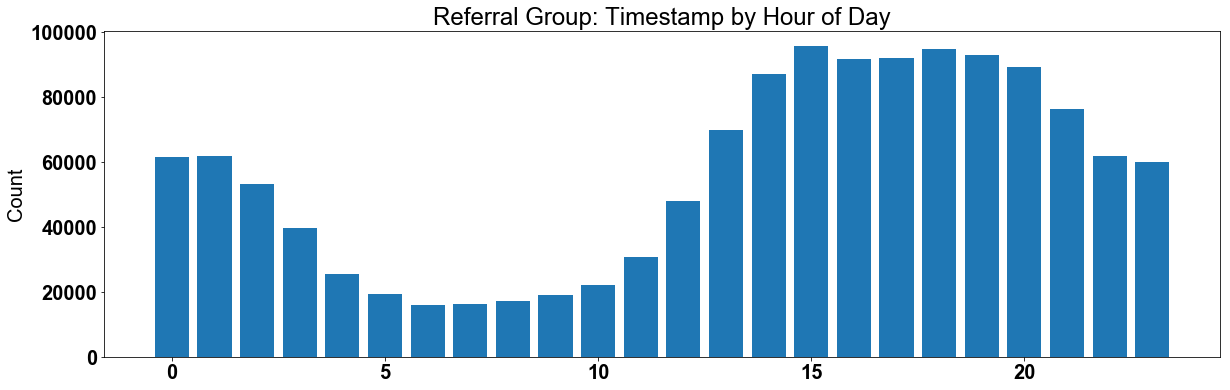

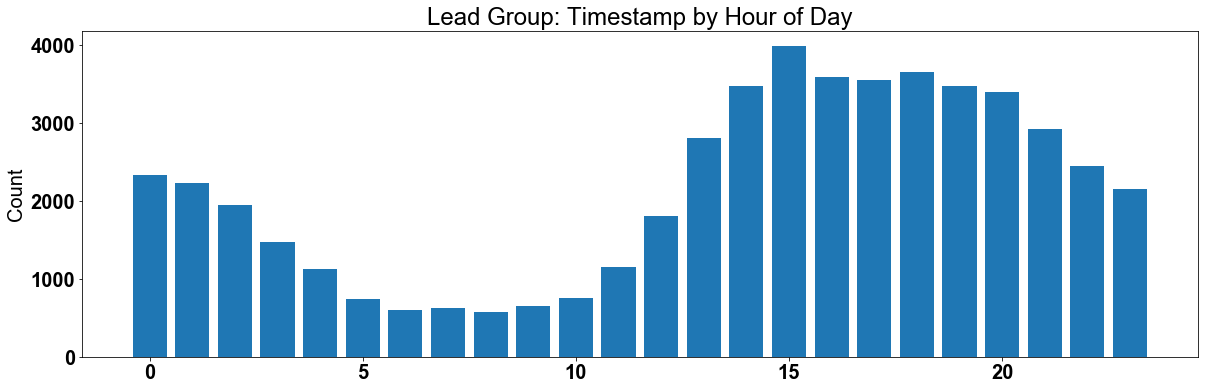

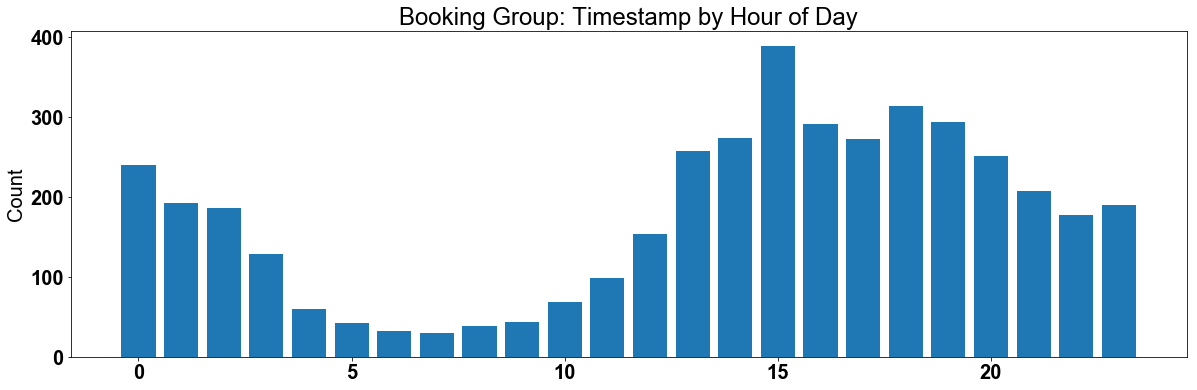

In [89]:
# Plot distribution of hours of day for referral only, lead, and booking groups

df_referral = df_good_ids[(df_good_ids['lead_visitor-id_count'].isnull()) & 
                     (df_good_ids['booking_visitor-id_count'].isnull())]

referral_ts_hour_freq = pd.crosstab(index=df_referral['ts_hour_of_day'], columns='hour_of_day')

df_lead = df_good_ids[(df_good_ids['lead_visitor-id_count'].notnull()) & 
                     (df_good_ids['booking_visitor-id_count'].isnull())]

lead_ts_hour_freq = pd.crosstab(index=df_lead['ts_hour_of_day'], columns='hour_of_day')

df_booking  = df_good_ids[(df_good_ids['lead_visitor-id_count'].notnull()) & 
                     (df_good_ids['booking_visitor-id_count'].notnull())]

booking_ts_hour_freq = pd.crosstab(index=df_booking['ts_hour_of_day'], columns=['hour_of_day'])

hours = list(range(0, 24))

# Referral group plot    
plt.figure(1)
plt.figure(figsize=(20,6))
plt.bar(hours, referral_ts_hour_freq.hour_of_day)
plt.ylabel('Count')
plt.title("Referral Group: Timestamp by Hour of Day")

# Lead group plot    
plt.figure(2)
plt.figure(figsize=(20,6))
plt.bar(hours, lead_ts_hour_freq.hour_of_day)
plt.ylabel('Count')
plt.title("Lead Group: Timestamp by Hour of Day")

# Booking group plot    
plt.figure(3)
plt.figure(figsize=(20,6))
plt.bar(hours, booking_ts_hour_freq.hour_of_day)
plt.ylabel('Count')
plt.title("Booking Group: Timestamp by Hour of Day")

## Modeling: Part 1

### Aim: predict whether a lead will be associated with a booking

Independent variables:
 - cumulative_referral_count - count of __referrals__ thus far for the visitor-ID assoicated with the record
 - cumulative_lead_count - count of __leads__ thus far for the visitor-ID
 - prior_booking_count - count of prior bookings associated with the visitor-ID
 - partner-code - hotel partner for referral
 - lead_rate-partner - hotel partner for lead
 - cumulative_referral_hotel_count - count of unique __referral hotel partners__ thus far for the visitor-ID
 - cumulative_lead_hotel_count - count of unique __lead hotel partners__ thus far for the visitor-ID
 - referral_to_lead_ts_mins - difference between referral time stamp and lead time stamp
 - ts_to_check_in - difference between referral time stamp and referral check-in date
 - cumulative_location-tid_count - count of unique __location-tid__ values thus far for the visitor-ID
 - cumulative_udicode_count - count of unique __udicode__ values thus far for the visitor-ID
 - time_from_first_record_mins - length of time between referral timestamp and first timestamp on record for the visitor-ID
 - ts_day_of_week - day of week of referral timestamp
 - ts_hour_of_day - hour of day of referral timestamp
 
Response variable:
 - booking - was there a booking associated with the record?

In [90]:
# Add a response variable to df_good_ids to indicate whether booking is associated with the record
df_good_ids['booking'] = np.where(df_good_ids['booking_visitor-id'].notnull(), 1, 0)

# Check df_good_ids
df_good_ids[['booking_visitor-id', 'booking']][df_good_ids['visitor-id']=='59a85897-61a1-4c13-932f-8b8e12538be5'].head(5)

,booking_visitor-id,booking
882461,NaN,0
882462,NaN,0
882463,NaN,0
882464,NaN,0
882465,59a85897-61a1-4c13-932f-8b8e12538be5,1


In [91]:
# Subset data for records with a lead
book_df = df_good_ids[df_good_ids['lead_visitor-id'].notnull()]

# Subset to include variables of interest
book_df = book_df[['visitor-id', 'cumulative_referral_count', 'cumulative_lead_count', 
                   'prior_booking_count', 'cumulative_referral_hotel_count', 'cumulative_lead_hotel_count', 
                   'referral_to_lead_ts_mins', 'ts_to_check-in', 'ts_day_of_week', 'ts_hour_of_day',
                   'partner-code', 'lead_rate-partner',
                   'cumulative_location-tid_count', 'cumulative_udicode_count', 
                   'time_from_first_record_mins', 'booking']]


# Check book_df
book_df.head()

,visitor-id,cumulative_referral_count,cumulative_lead_count,prior_booking_count,cumulative_referral_hotel_count,cumulative_lead_hotel_count,referral_to_lead_ts_mins,ts_to_check-in,ts_day_of_week,ts_hour_of_day,partner-code,lead_rate-partner,cumulative_location-tid_count,cumulative_udicode_count,time_from_first_record_mins,booking
21,0475559a-baa6-47eb-94f3-1d054ead644f,1,1.0,0.0,1.0,1.0,5.750000,1.0,Thursday,22,HLTN,MRT,1.0,0.0,0.000000,0
124,181d7271-07d4-4852-94ef-bebef1f5bf64,2,1.0,0.0,2.0,1.0,29.900000,NaN,Monday,22,HYAT,HYAT,1.0,1.0,4.250000,0
173,1e7444bb-f2a5-4731-9471-82808d641d98,1,1.0,0.0,1.0,1.0,5.850000,3.0,Friday,10,IHG,IHG,1.0,0.0,0.000000,0
207,22770c0a-ccf0-4222-9a28-f16d1d52ac1e,3,1.0,0.0,3.0,1.0,8.033333,NaN,Tuesday,1,IHG,IHG,2.0,1.0,96.616667,0
255,2cf1f85b-13eb-44df-9f72-fe19132ef5c1,3,1.0,0.0,2.0,1.0,2.516667,14.0,Wednesday,12,WYND,WYND,1.0,0.0,32.416667,0


In [92]:
# Check for missing values
book_df.isnull().sum()

visitor-id                            0
cumulative_referral_count             0
cumulative_lead_count                 0
prior_booking_count                   0
cumulative_referral_hotel_count       0
cumulative_lead_hotel_count           0
referral_to_lead_ts_mins              0
ts_to_check-in                     4309
ts_day_of_week                        0
ts_hour_of_day                        0
partner-code                          0
lead_rate-partner                     0
cumulative_location-tid_count         0
cumulative_udicode_count              0
time_from_first_record_mins           0
booking                               0
dtype: int64

In [93]:
# ts_to_check-in is unknown for 4309 records - what percentage of the data is this?
len(book_df[book_df['ts_to_check-in'].isnull()]) / len(book_df) * 100

14.913646904094419

14.9% is a lot of data to lose. For now, I will delete these records, but an approach to use in future development would be to check these visitor-ids to see if they have other check-in values in the data that we could impute to replace the missing values.

In [94]:
# Drop cases of missing ts_to_check-in
book_df = book_df[book_df['ts_to_check-in'].notnull()]

# Remove visitor-id
book_df = book_df.drop('visitor-id', axis=1)

# Check again for missing values
book_df.isnull().sum()

cumulative_referral_count          0
cumulative_lead_count              0
prior_booking_count                0
cumulative_referral_hotel_count    0
cumulative_lead_hotel_count        0
referral_to_lead_ts_mins           0
ts_to_check-in                     0
ts_day_of_week                     0
ts_hour_of_day                     0
partner-code                       0
lead_rate-partner                  0
cumulative_location-tid_count      0
cumulative_udicode_count           0
time_from_first_record_mins        0
booking                            0
dtype: int64

In [95]:
# Change ts_hour_of_day to categorical variable
book_df['ts_hour_of_day'] = book_df['ts_hour_of_day'].astype('category')

# Create dummy variables for partner-code, lead_rate-partner, ts_day_of_week, ts_hour_of_day
book_df_dummy = pd.get_dummies(book_df[['partner-code', 'lead_rate-partner', 'ts_hour_of_day', 'ts_day_of_week']])

In [96]:
# Join data 
book_df = pd.concat([book_df, book_df_dummy], axis=1)
book_df = book_df.drop(['partner-code', 'lead_rate-partner', 'ts_hour_of_day', 'ts_day_of_week'], axis=1)

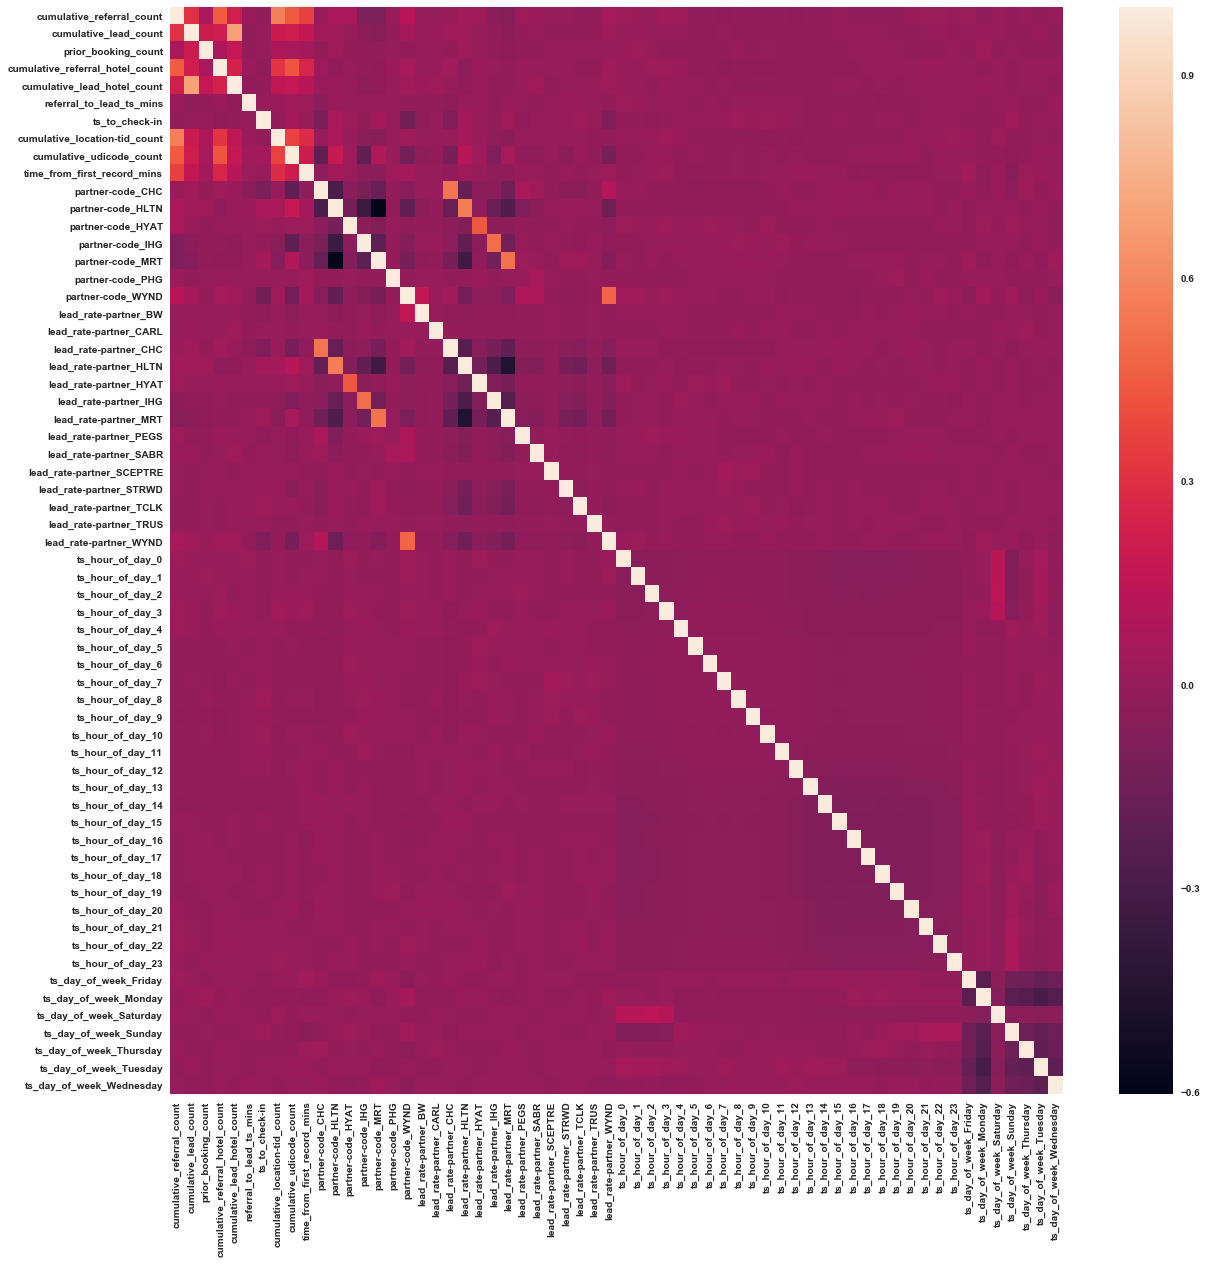

In [97]:
# Check correlation between independent variables
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.subplots(figsize=(20,20))
sns.heatmap(book_df.drop('booking', axis=1).corr())

_Observations_: No issues with the correlation plot

In [98]:
# Split data into training and testing sets
X = book_df.drop(['booking'], axis=1) # independent variables
y = book_df['booking'] # response variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=12)

In [99]:
# Check training data
X_train.shape

(22125, 62)

In [100]:
# Logistic regression, k-nearest neighbors, random forest, AdaBoost, GBRT, and XGB models
logistic = LogisticRegression()
knn = neighbors.KNeighborsClassifier()
rf = RandomForestClassifier(n_estimators=25, random_state=12)
ab = AdaBoostClassifier(n_estimators=100, random_state=12)
gbrt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=12)
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1)

print('LogisticRegression score: %f' % logistic.fit(X_train, y_train).score(X_test, y_test))
print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('RandomForestClassifier score: %f' % rf.fit(X_train, y_train).score(X_test, y_test))
print('AdaBoostClassifier score: %f' % ab.fit(X_train, y_train).score(X_test, y_test))
print('GradientBoostingClassifier score: %f' % gbrt.fit(X_train, y_train).score(X_test, y_test))
print('XGBClassifier score: %f' % xgb_model.fit(X_train, y_train).score(X_test, y_test))

LogisticRegression score: 0.679138
KNN score: 0.915006
RandomForestClassifier score: 0.917039
AdaBoostClassifier score: 0.926393
GradientBoostingClassifier score: 0.927613
XGBClassifier score: 0.927613


In [101]:
# Confusion matrix - logsitic
y_pred = logistic.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[1649,  632],
       [  88,   90]])

In [102]:
# Confusion matrix - knn
y_pred = knn.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2244,   37],
       [ 172,    6]])

In [103]:
# Confusion matrix - random forest
y_pred = rf.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2248,   33],
       [ 171,    7]])

In [104]:
# Confusion matrix - AdaBoost
y_pred = ab.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2278,    3],
       [ 178,    0]])

In [105]:
# Confusion matrix - GBRT
y_pred = gbrt.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2281,    0],
       [ 178,    0]])

In [106]:
# Confusion matrix - XGB
y_pred = xgb_model.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2281,    0],
       [ 178,    0]])

_Observation_: All 5 models have fairly good accuracy, but this is __not__ a good measure of their performance as they classify almost all observations as not resulting in a booking. This is most likely due at least in part to class imbalance, so I will over-sample from the cases where a booking occurred to balance the classes out.

In [107]:
# Find the number of 0 cases and 1 cases in y_train
print(sum(y_train))
print(len(y_train[y_train==0]))
print(len(y_train))

1680
20445
22125


In [108]:
# Oversample on the training data
sm = SMOTE(random_state=12, ratio={0:20445, 1:10000})
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

logistic.fit(X_train_res, y_train_res)
knn.fit(X_train_res, y_train_res)
rf.fit(X_train_res, y_train_res)
ab.fit(X_train_res, y_train_res)
gbrt.fit(X_train_res, y_train_res)
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [109]:
print('LogisticRegression score: %f'% logistic.score(X_test, y_test))
print('KNN score: %f' % knn.score(X_test, y_test))
print('RandomForestClassifier score: %f' % rf.score(X_test, y_test))
print('AdaBoostClassifier score: %f' % ab.fit(X_train, y_train).score(X_test, y_test))
print('GradientBoostingClassifier score: %f' % gbrt.score(X_test, y_test))
print('XGBClassifierClassifier score: %f' % xgb_model.score(X_test.as_matrix(), y_test))

LogisticRegression score: 0.312322
KNN score: 0.694185
RandomForestClassifier score: 0.912159
AdaBoostClassifier score: 0.926393
GradientBoostingClassifier score: 0.923546
XGBClassifierClassifier score: 0.926393


In [110]:
# Confusion matrix - logsitic
y_pred = logistic.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[ 732, 1549],
       [  18,  160]])

In [111]:
# Confusion matrix - knn
y_pred = knn.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[1636,  645],
       [ 107,   71]])

In [112]:
# Confusion matrix - random forest
y_pred = rf.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[2232,   49],
       [ 167,   11]])

In [113]:
# Confusion matrix - AdaBoost
y_pred = ab.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[2278,    3],
       [ 178,    0]])

In [114]:
# Confusion matrix - GBRT
y_pred = gbrt.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[2270,   11],
       [ 177,    1]])

In [115]:
# Confusion matrix - XGB
y_pred = xgb_model.predict(X_test.as_matrix())
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[2277,    4],
       [ 177,    1]])

_Observation_: The random forest classifier with the oversampled booking cases in training performs the best of the 5 models. However, the precision and recall for the booking class is still very low (0.18, 0.06).

In [116]:
# Precision and recall scores for both classes in random forest classifier
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.98      0.95      2281
          1       0.18      0.06      0.09       178

avg / total       0.88      0.91      0.89      2459



In [117]:
book_df.corr()['booking'].sort_values()

partner-code_CHC                  -0.072906
lead_rate-partner_CHC             -0.060787
lead_rate-partner_TCLK            -0.055255
lead_rate-partner_WYND            -0.050961
lead_rate-partner_HYAT            -0.048643
partner-code_WYND                 -0.040101
ts_to_check-in                    -0.038737
lead_rate-partner_STRWD           -0.036985
ts_day_of_week_Wednesday          -0.035128
lead_rate-partner_SABR            -0.030911
ts_day_of_week_Thursday           -0.026255
partner-code_HYAT                 -0.024509
ts_day_of_week_Friday             -0.022644
ts_day_of_week_Saturday           -0.020020
cumulative_referral_hotel_count   -0.017230
lead_rate-partner_PEGS            -0.015616
cumulative_referral_count         -0.014948
ts_hour_of_day_6                  -0.013544
ts_hour_of_day_7                  -0.013212
lead_rate-partner_BW              -0.012107
lead_rate-partner_TRUS            -0.011829
ts_hour_of_day_4                  -0.010757
referral_to_lead_ts_mins        

## Modeling: Part 2

### Aim: predict whether a visitor with a lead will have a booking

Independent variables:
 - referral_visitor-id_count - total number of __referrals__ for the visitor-ID
 - lead_visitor-id_count - total number of __leads__ for the visitor-ID
 - referral_hotel_count - total number of unique __referral hotels__ for the visitor-ID
 - lead_hotel_count - total number of unique __lead hotels__ for the visitor-ID
 - referral_to_lead_ts_mins_mean - mean time between referral to lead for the visitor-ID
 - referral_to_lead_ts_mins_range - difference between max and min times from referral to lead for visitor-ID
 - ts_to_check_in_mean - mean time between referral ts and check-in date for the visitor-ID
 - ts_to_check_in_range - difference between max and min times from referral to check-in for visitor-ID
 - check_in_unique_values - number of unique values for check-in date for visitor-ID
 - location-tid_count - count of unique location-tids for the visitor-ID
 - udicode_count - count of unique udicodes for the visitor-ID
 - time_from_first_record_mins_mean - mean time between first referral ts and each record for visitor-ID
 - time_from_first_record_mins_range - difference between max and min of time_from_first_record_mins for visitor-ID
 
Response variable:
 - ever_booked - was there at least one booking associated with the visitor-ID?

In [118]:
# Subset data for records with a lead
book_df2 = df_good_ids[df_good_ids['lead_visitor-id'].notnull()]

# Subset to include variables of interest
book_df2 = book_df2[['visitor-id', 'referral_visitor-id_count', 'lead_visitor-id_count',
                     'referral_hotel_count', 'lead_hotel_count', 'referral_to_lead_ts_mins_mean',
                     'referral_to_lead_ts_mins_range', 'ts_to_check-in_mean', 'ts_to_check-in_range',
                     'check-in_unique_values', 'location-tid_count', 'udicode_count', 
                     'time_from_first_record_mins_mean', 'time_from_first_record_mins_range',
                     'booking']]

# Add identifier indicating if visitor ever booked
booked = book_df2[book_df2['booking']==1]
book_df2['ever_booked'] = np.where(book_df2['visitor-id'].isin(booked['visitor-id']), 1, 0)

# Drop 'booking'
book_df2.drop('booking', axis=1, inplace=True)

# Remove duplicates
book_df2.drop_duplicates(inplace=True)

# Check length
print(len(book_df2)==len(book_df2['visitor-id'].unique()))

# Check book_df2
book_df2[book_df2['visitor-id']=='59a85897-61a1-4c13-932f-8b8e12538be5'].head()

True


,visitor-id,referral_visitor-id_count,lead_visitor-id_count,referral_hotel_count,lead_hotel_count,referral_to_lead_ts_mins_mean,referral_to_lead_ts_mins_range,ts_to_check-in_mean,ts_to_check-in_range,check-in_unique_values,location-tid_count,udicode_count,time_from_first_record_mins_mean,time_from_first_record_mins_range,ever_booked
882465,59a85897-61a1-4c13-932f-8b8e12538be5,20,3.0,5.0,2.0,0.227778,0.133333,4.526316,13.0,4,7.0,9.0,130.6575,306.916667,1


In [119]:
# Check for missing values
book_df2.isnull().sum()

visitor-id                              0
referral_visitor-id_count               0
lead_visitor-id_count                   0
referral_hotel_count                    0
lead_hotel_count                        0
referral_to_lead_ts_mins_mean           0
referral_to_lead_ts_mins_range          0
ts_to_check-in_mean                  3310
ts_to_check-in_range                 3310
check-in_unique_values                  0
location-tid_count                      0
udicode_count                           0
time_from_first_record_mins_mean        0
time_from_first_record_mins_range       0
ever_booked                             0
dtype: int64

In [120]:
# ts_to_check-in data is unknown for 3310 records - what percentage of the data is this?
len(book_df2[book_df2['ts_to_check-in_mean'].isnull()]) / len(book_df2) * 100

11.832838808851392

11.8% is a lot of data to lose. For now, as before, I will delete these observations; in future development multiple imputation could be used, or the range of data could be expanded to include more observations in the event that visitors with missing check-ins might have them for dates outside the current range.

In [121]:
# Remove cases where ts_to_check-in_mean is null
book_df2 = book_df2[book_df2['ts_to_check-in_mean'].notnull()]

# Drop visitor-ID
book_df2.drop('visitor-id', axis=1, inplace=True)

# Check again for missing values
book_df2.isnull().sum()

referral_visitor-id_count            0
lead_visitor-id_count                0
referral_hotel_count                 0
lead_hotel_count                     0
referral_to_lead_ts_mins_mean        0
referral_to_lead_ts_mins_range       0
ts_to_check-in_mean                  0
ts_to_check-in_range                 0
check-in_unique_values               0
location-tid_count                   0
udicode_count                        0
time_from_first_record_mins_mean     0
time_from_first_record_mins_range    0
ever_booked                          0
dtype: int64

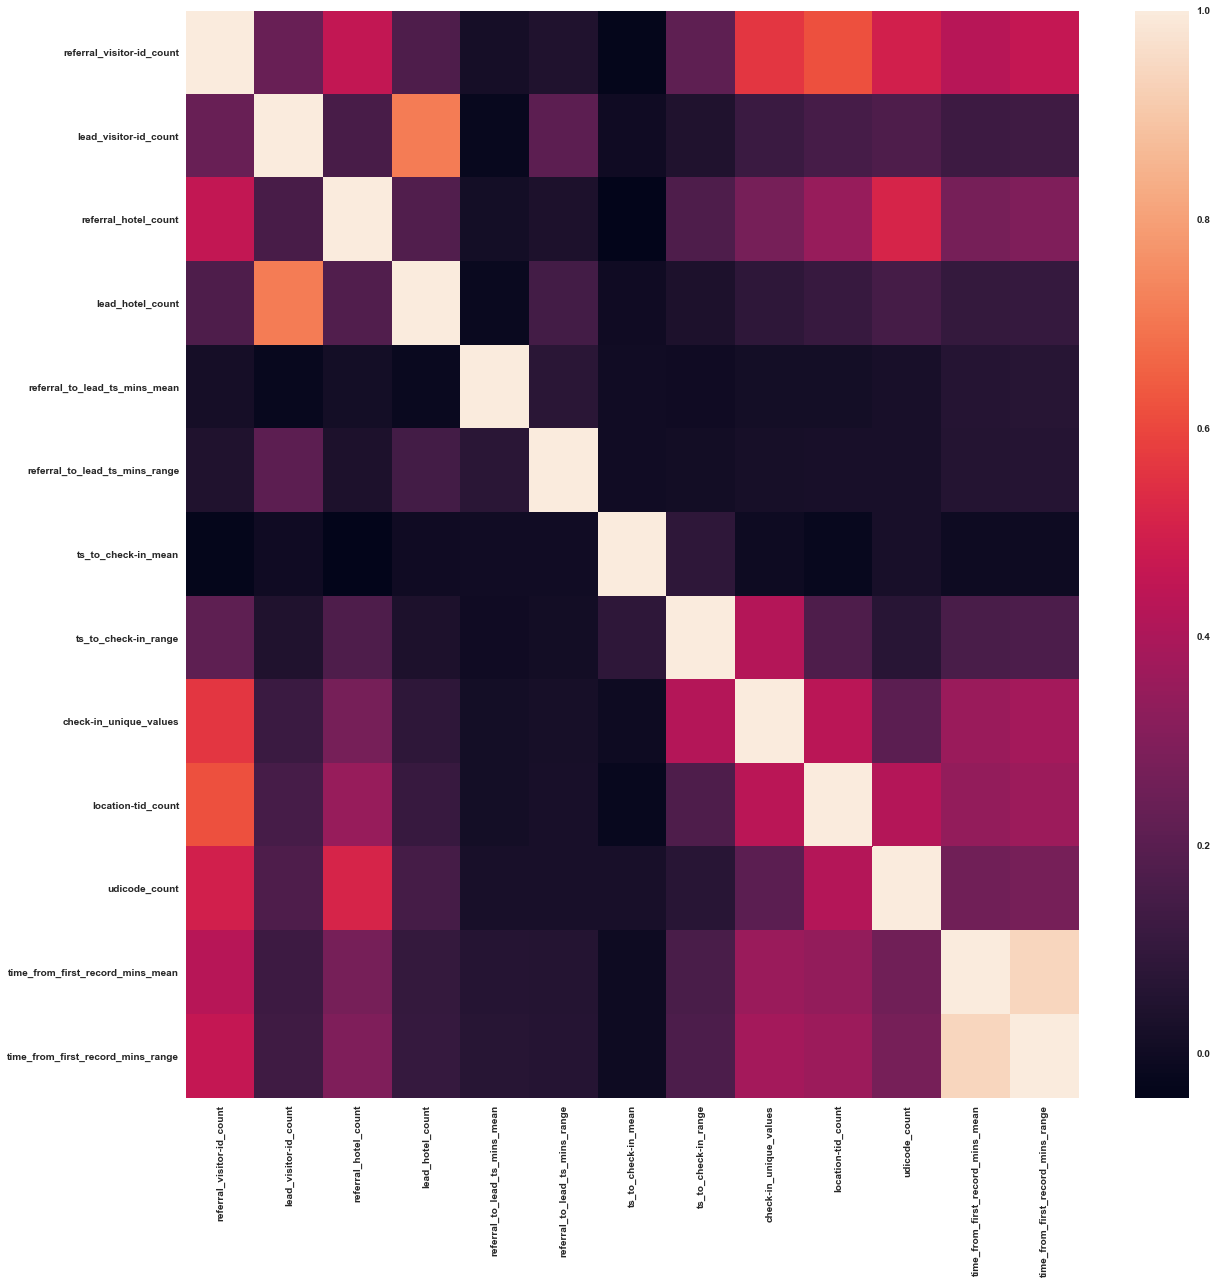

In [122]:
# Check correlation between independent variables
plt.subplots(figsize=(20,20))
sns.heatmap(book_df2.drop('ever_booked', axis=1).corr())

In [123]:
# time_from_first_record_mins_mean seems to be contributing the same information as time_from_first_record_mins_range, 
# so delete the range variable
book_df2.drop('time_from_first_record_mins_range', axis=1, inplace=True)

In [124]:
# Split data into training and testing sets
X = book_df2.drop(['ever_booked'], axis=1) # independent variables
y = book_df2['ever_booked'] # response variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=12)

In [125]:
# Check training data
X_train.shape

(22196, 12)

In [126]:
# Logistic regression, k-nearest neighbors, random forest, AdaBoost, GBRT, and XGB models
logistic = LogisticRegression()
knn = neighbors.KNeighborsClassifier()
rf = RandomForestClassifier(n_estimators=25, random_state=12)
ab = AdaBoostClassifier(n_estimators=100, random_state=12)
gbrt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=12)
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1)

print('LogisticRegression score: %f' % logistic.fit(X_train, y_train).score(X_test, y_test))
print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('RandomForestClassifier score: %f' % rf.fit(X_train, y_train).score(X_test, y_test))
print('AdaBoostClassifier score: %f' % ab.fit(X_train, y_train).score(X_test, y_test))
print('GradientBoostingClassifier score: %f' % gbrt.fit(X_train, y_train).score(X_test, y_test))
print('XGBClassifier score: %f' % xgb_model.fit(X_train, y_train).score(X_test, y_test))

LogisticRegression score: 0.908391
KNN score: 0.911634
RandomForestClassifier score: 0.904337
AdaBoostClassifier score: 0.915282
GradientBoostingClassifier score: 0.916092
XGBClassifier score: 0.916498


In [127]:
# Confusion matrix - logsitic
y_pred = logistic.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2251,    9],
       [ 205,    2]])

In [128]:
# Confusion matrix - knn
y_pred = knn.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2247,   13],
       [ 205,    2]])

In [129]:
# Confusion matrix - random forest
y_pred = rf.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2221,   39],
       [ 197,   10]])

In [130]:
# Confusion matrix - AdaBoost
y_pred = ab.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2258,    2],
       [ 207,    0]])

In [131]:
# Confusion matrix - GBRT
y_pred = gbrt.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2260,    0],
       [ 207,    0]])

In [132]:
# Confusion matrix - XGB
y_pred = xgb_model.predict(X_test)
conf_matr = confusion_matrix(np.asarray(y_test), np.asarray(y_pred))
conf_matr

array([[2260,    0],
       [ 206,    1]])

_Observation_: All 5 models have fairly good accuracy, but as noted in the previous modeling, this is __not__ a good measure of their performance as they classify almost all observations as not resulting in a booking. As with the previous approach, I will upsample the booking cases to try to address the issue.

In [133]:
# Find the number of 0 cases and 1 cases in y_train
print(sum(y_train))
print(len(y_train[y_train==0]))
print(len(y_train))

1736
20460
22196


In [134]:
# Oversample on the training data
sm = SMOTE(random_state=12, ratio={0:20460, 1:9000})
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

logistic.fit(X_train_res, y_train_res)
knn.fit(X_train_res, y_train_res)
rf.fit(X_train_res, y_train_res)
ab.fit(X_train_res, y_train_res)
gbrt.fit(X_train_res, y_train_res)
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [135]:
print('LogisticRegression score: %f'% logistic.score(X_test, y_test))
print('KNN score: %f' % knn.score(X_test, y_test))
print('RandomForestClassifier score: %f' % rf.score(X_test, y_test))
print('AdaBoostClassifier score: %f' % ab.fit(X_train, y_train).score(X_test, y_test))
print('GradientBoostingClassifier score: %f' % gbrt.score(X_test, y_test))
print('XGBClassifierClassifier score: %f' % xgb_model.score(X_test.as_matrix(), y_test))

LogisticRegression score: 0.910823
KNN score: 0.783543
RandomForestClassifier score: 0.875152
AdaBoostClassifier score: 0.915282
GradientBoostingClassifier score: 0.896230
XGBClassifierClassifier score: 0.899473


In [136]:
# Confusion matrix - logsitic
y_pred = logistic.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[ 761, 1499],
       [  54,  153]])

In [137]:
# Confusion matrix - knn
y_pred = knn.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[1881,  379],
       [ 155,   52]])

In [138]:
# Confusion matrix - random forest
y_pred = rf.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[2139,  121],
       [ 187,   20]])

In [139]:
# Confusion matrix - AdaBoost
y_pred = ab.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[2258,    2],
       [ 207,    0]])

In [140]:
# Confusion matrix - GBRT
y_pred = gbrt.predict(X_test)
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[2192,   68],
       [ 188,   19]])

In [141]:
# Confusion matrix - XGB
y_pred = xgb_model.predict(X_test.as_matrix())
confusion_matrix(np.asarray(y_test), np.asarray(y_pred))

array([[2204,   56],
       [ 192,   15]])

_Observation_: The XGB classifier with the oversampled booking cases in training performs the best of the 5 models, and performs better than the random forest model predicting whether a record with a lead will have a booking. However, the precision and recall for the booking class is still very low (0.21, 0.07).

In [142]:
# Precision and recall scores for both classes in XGB classifier
y_pred = xgb_model.predict(X_test.as_matrix())
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95      2260
          1       0.21      0.07      0.11       207

avg / total       0.86      0.90      0.88      2467



In [143]:
book_df2.corr()['ever_booked'].sort_values()

ts_to_check-in_mean                -0.042308
referral_hotel_count               -0.026019
ts_to_check-in_range               -0.018784
referral_to_lead_ts_mins_mean      -0.012371
check-in_unique_values             -0.007118
referral_visitor-id_count          -0.006352
referral_to_lead_ts_mins_range      0.004322
lead_hotel_count                    0.009818
time_from_first_record_mins_mean    0.012481
location-tid_count                  0.018566
udicode_count                       0.019562
lead_visitor-id_count               0.022889
ever_booked                         1.000000
Name: ever_booked, dtype: float64